In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/DNN_Mgard/notebook")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial import Delaunay
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import copy
from sklearn import preprocessing

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib import colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import mplot3d
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2

import seaborn as sns
sns.set_style("whitegrid")

current_palette = sns.color_palette("deep")
# current_palette = sns.color_palette("Set3")

fontsize=35

from scripts.util import load_var, scatter3D

In [3]:
matplotlib.__version__

'3.7.1'

In [4]:
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return r'${}e{}$'.format(a, b)

In [5]:
import functools
import time

def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"{func}:{elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

In [6]:
# Those old ones before 08/03/2023
Time_paths_old = [
    "datasets/Warpx_00300_bx/run_mgard_1e-1_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-3_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-5_full.csv",
    "datasets/Warpx_00300_bx/run_mgard_1e-7_full.csv",
    "datasets/Warpx_00300_ex/run_mgard_1e-1_full.csv",
    "datasets/Nyx_baryon_density/run_mgard_1e-1_full.csv",
    "datasets/Nyx_dark_matter_density/run_mgard_1e-1_full.csv",
    "datasets/Nyx_temperature/run_mgard_1e-1_full.csv",
    "datasets/Nyx_velocity_x/run_mgard_1e-1_full.csv",
    "datasets/Hurrican_cloud48_log/run_mgard_1e-1_full.csv",
    "datasets/Hurrican_qcloud48_log/run_mgard_1e-1_full.csv",
    ]

# New applications across error bounds - 08/03/2023.
Time_paths_new = [
    # hurricane
    # "datasets/cloudf48_log_1.00e-06.csv",
    "datasets/cloudf48_log_1.01e-04.csv",
    "datasets/cloudf48_log_1.02e-02.csv",
    "datasets/cloudf48_log_1.02e+00.csv",
    # "datasets/precipf48_log_3.50e-06.csv",
    "datasets/precipf48_log_3.58e-04.csv",
    "datasets/precipf48_log_3.58e-02.csv",
    "datasets/precipf48_log_3.58e+00.csv",
    # "datasets/qgraupf48_log_3.50e-06.csv",
    "datasets/qgraupf48_log_3.57e-04.csv",
    "datasets/qgraupf48_log_3.58e-02.csv",
    "datasets/qgraupf48_log_3.58e+00.csv",
    # "datasets/qicef48_log_1.80e-06.csv",
    "datasets/qicef48_log_1.86e-04.csv",
    "datasets/qicef48_log_1.87e-02.csv",
    "datasets/qicef48_log_1.87e+00.csv",

    ##  nyx
    # "datasets/baryon_density_1.16e-02.csv",
    "datasets/baryon_density_1.16e+00.csv",
    "datasets/baryon_density_1.16e+02.csv",
    "datasets/baryon_density_1.16e+04.csv",
    # "datasets/dark_matter_density_1.38e-03.csv",
    "datasets/dark_matter_density_1.38e-01.csv",
    "datasets/dark_matter_density_1.38e+01.csv",
    "datasets/dark_matter_density_1.38e+03.csv",
    # "datasets/temperature_4.78e-01.csv",
    "datasets/temperature_4.78e+01.csv",
    "datasets/temperature_4.78e+03.csv",
    "datasets/temperature_4.78e+05.csv",
    # "datasets/velocity_x_8.23e+00.csv",
    "datasets/velocity_x_8.23e+02.csv",
    "datasets/velocity_x_8.23e+04.csv",
    "datasets/velocity_x_8.23e+06.csv",

    ### scale
    # "datasets/pres-98x1200x1200_9.95e-03.csv",
    "datasets/pres-98x1200x1200_9.95e-01.csv",
    "datasets/pres-98x1200x1200_9.95e+01.csv",
    "datasets/pres-98x1200x1200_9.95e+03.csv",
    # "datasets/qc-98x1200x1200_3.01e-10.csv",
    "datasets/qc-98x1200x1200_3.01e-08.csv",
    "datasets/qc-98x1200x1200_3.01e-06.csv",
    "datasets/qc-98x1200x1200_3.01e-04.csv",
    # "datasets/qg-98x1200x1200_1.49e-09.csv",
    "datasets/qg-98x1200x1200_1.49e-07.csv",
    "datasets/qg-98x1200x1200_1.49e-05.csv",
    "datasets/qg-98x1200x1200_1.49e-03.csv",
    # "datasets/qi-98x1200x1200_1.60e-10.csv",
    "datasets/qi-98x1200x1200_1.60e-08.csv",
    "datasets/qi-98x1200x1200_1.60e-06.csv",
    "datasets/qi-98x1200x1200_1.60e-04.csv",
    ]

Threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10,
             0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,
             0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30,
             0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]

Time_paths_lvl2 = ["datasets/baryon_density_1.16e+04_lvl2.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl2.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl2.csv"]

Time_paths_lvl3 = ["datasets/baryon_density_1.16e+04_lvl3.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl3.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]

Time_paths_lvl4 = ["datasets/baryon_density_1.16e+04_lvl4.csv",
                   "datasets/cloudf48_log_1.02e+00_lvl4.csv",
                   "datasets/pres-98x1200x1200_9.95e+03_lvl4.csv"]

## Data analytics

In [ ]:
def scatter3D(data, axs, var, alpha, elev=30, azim=45, roll=0):
    xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data)
    vdata = data[var].values

    if var == "estimated_error":
        cmap = "plasma"
    elif var == "MaxErr":
        cmap = "plasma"
    elif var == "Total_retrieve_size":
        cmap = "viridis"

    axs.view_init(elev=elev, azim=azim) # , roll=roll
    if var == "MaxErr":
        img = axs.scatter(xdata, ydata, zdata, c=vdata, cmap=cmap, norm=colors.LogNorm(), s=3, alpha=alpha) # ,#vmin=np.min(vdata), vmax=np.max(vdata),
    elif var == "Total_retrieve_size":
        img = axs.scatter(xdata, ydata, zdata, c=vdata, cmap=cmap, vmin=np.min(vdata), vmax=np.max(vdata), s=3, alpha=alpha) # ,
    # img = axs.scatter(xdata, ydata, zdata, c=vdata, cmap=cmap, s=3, norm=colors.LogNorm(vmin=np.min(vdata), vmax=np.max(vdata)), alpha=alpha) # norm=colors.LogNorm(),#
    # print(np.min(vdata), np.max(vdata))

    if azim in [0, 45]:
        # try not to change this
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey',  alpha=.5)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='grey',  alpha=.5)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey',  alpha=.5)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)

    if azim == 225:
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey', alpha=.5)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='grey', alpha=.5)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='grey', alpha=.5)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)

        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(0, 0, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)
        axs.plot(np.linspace(6, 6, num=len(xdata)), np.linspace(0, 6, num=len(xdata)), np.linspace(6, 6, num=len(xdata)), color='black', alpha=1)

    axs.set_xlim(0, 6)
    axs.set_ylim(0, 6)
    axs.set_zlim(0, 6)

    axs.set_xlabel('C0', labelpad=18, fontsize=fontsize)
    axs.set_ylabel('C1', labelpad=18, fontsize=fontsize)
    axs.set_zlabel('C2', labelpad=6, fontsize=fontsize)
    axs.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_zticks([0, 1, 2, 3, 4, 5, 6]);
    axs.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    axs.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    axs.set_zticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    return img

/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_72474/3262833477.py:50: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


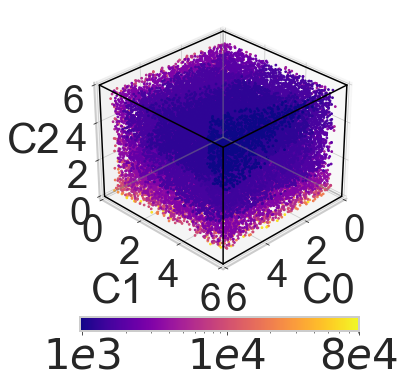

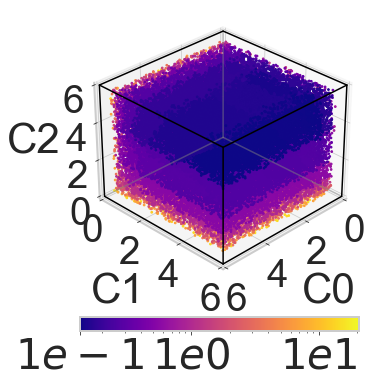

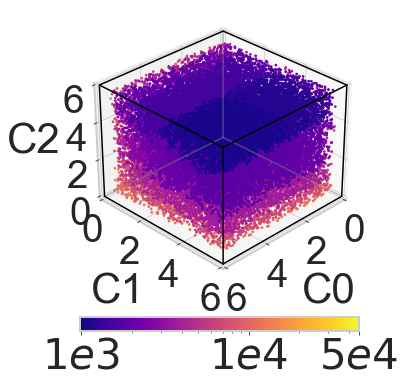

In [ ]:
def plot_scatter3D(time_path):
    data0 = pd.read_csv(time_path).drop_duplicates()
    dname = time_path.split("/")[1]
    reqerr = data0["Requested_tolerance"].values[0]
    c0 = data0[(data0.MaxErr > reqerr)].c0.values
    c1 = data0[(data0.MaxErr > reqerr)].c1.values
    c2 = data0[(data0.MaxErr > reqerr)].c2.values

    plt.rcParams["figure.figsize"] = [5, 5*1.2]
    fig = plt.figure()

    ax2 = fig.add_subplot(1, 1, 1, projection='3d')
    # ax2.set_title("rotation=45", fontsize=fontsize)
    img = scatter3D(data0, ax2, "MaxErr", 1, 30, 45, 0) # estimated_error, or MaxErr, or Total_retrieve_size
    vdata = data0["MaxErr"].values
    # img = scatter3D(data0, ax2, "Total_retrieve_size", .8, 30, 45, 0)
    cbar = fig.colorbar(img, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.1)
    cbar.ax.tick_params(labelsize=fontsize*1.2)

    # # I/O
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([np.min(vdata), 1e4, 2e4, np.max(vdata)])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([np.min(vdata), 5e6, 1e7])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([np.min(vdata), 5e6, np.max(vdata)])

    # MaxErr
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e3, 1e4, np.max(vdata)])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([np.min(vdata), 1e0, 1e1])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e3, 1e4, np.max(vdata)])

    ax2.set_xlim(0, 6)
    ax2.set_ylim(0, 6)
    ax2.set_zlim(0, 6)
    # plt.show()
    ax2.set_xticks([0, 2, 4, 6]);
    ax2.set_yticks([0, 2, 4, 6]);
    ax2.set_zticks([0, 2, 4, 6]);
    ax2.set_xticklabels([0, 2, 4, 6], fontsize=fontsize*1.1);
    ax2.set_yticklabels([0, 2, 4, 6], fontsize=fontsize*1.1);
    ax2.set_zticklabels([0, 2, 4, 6], fontsize=fontsize*1.1);
    ax2.set_xlabel('C0', labelpad=25, fontsize=fontsize*1.2)
    ax2.set_ylabel('C1', labelpad=25, fontsize=fontsize*1.2)
    ax2.set_zlabel('C2', labelpad=15, fontsize=fontsize*1.2)

    fig.tight_layout()
    plt.savefig("{}_scatter3D_maxerr.png".format(dname.replace("_lvl4", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="png")

for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]:
    plot_scatter3D(time_path)

/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_72474/3498854142.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


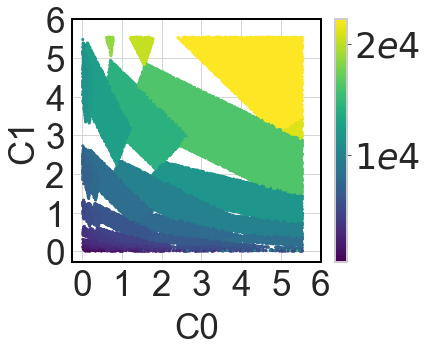

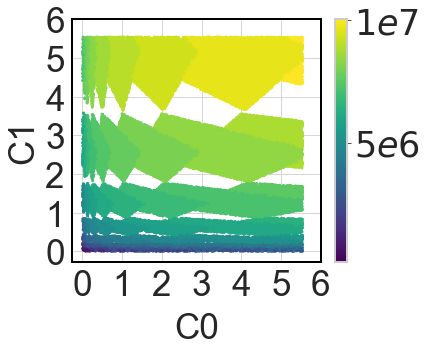

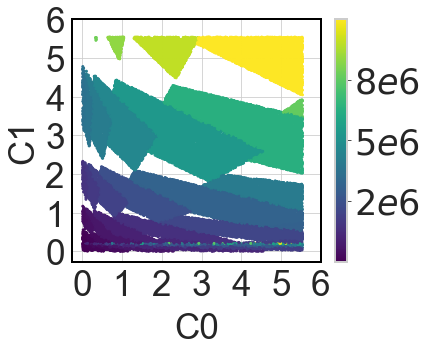

In [ ]:
def plot_slice_lvl2(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [5*1.2, 5]
    fig1 = plt.figure()

    # I/O size
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values
    ax1 = fig1.add_subplot(1, 1, 1)
    img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
        cbar.set_ticklabels([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
        cbar.set_ticklabels([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])
        cbar.set_ticklabels([1e6, 3e6, 5e6, 7e6, 9e6])

    fig1.tight_layout()
    fig1.show()

    # plt.savefig("{}_io_slice_lvl2.png".format(dname.replace("_lvl2", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="png")

threshold = .3
for time_path in ["datasets/baryon_density_1.16e+04_lvl2.csv", "datasets/cloudf48_log_1.02e+00_lvl2.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl2.csv"]:
    plot_slice_lvl2(time_path)

In [ ]:
def plot_slice_lvl3(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    # plt.rcParams["figure.figsize"] = [15*1.2, 5]
    plt.rcParams["figure.figsize"] = [5, 5]
    fig1 = plt.figure()

    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values
    medata = data0[(data0.estimated_error >= reqerr*(1-threshold))].MaxErr.values

    # # I/O size
    # ax1 = fig1.add_subplot(131)
    # img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    # cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    # cbar.ax.tick_params(labelsize=fontsize)
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([1e4, 2e4, 3e4])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # MEdata
    ax1 = fig1.add_subplot(111)
    img1 = ax1.scatter(c1, c2, c=medata, cmap="plasma", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    # cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([2e4, 4e4, 6e4, 8e4])
        cbar.set_ticklabels(["2e4", "4e4", "6e4", "8e4"], fontsize=fontsize)
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([4, 8, 12, 16])
        cbar.set_ticklabels(["4", "8", "12", "16"], fontsize=fontsize)
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e4, 2e4])
        cbar.set_ticklabels(["1e4", "2e4"], fontsize=fontsize)

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    # ax1 = fig1.add_subplot(132)
    # img1 = ax1.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    # cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    # # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    # cbar.ax.tick_params(labelsize=fontsize)
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([1e4, 2e4, 3e4])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    # ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    # ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    # ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    # ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    # ax1.spines["bottom"].set_color("black")
    # ax1.spines["top"].set_color("black")
    # ax1.spines["right"].set_color("black")
    # ax1.spines["left"].set_color("black")

    # ax1 = fig1.add_subplot(133)
    # img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    # cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.05, pad=0.05)
    # # cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="horizontal", fraction=0.05, pad=0.3)
    # cbar.ax.tick_params(labelsize=fontsize)
    # if dname == "baryon_density_1.16e+04_lvl3.csv":
    #     cbar.set_ticks([1e4, 2e4, 3e4])
    # elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
    #     cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    # elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
    #     cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    # ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    # ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    # ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    # ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    # ax1.spines["bottom"].set_color("black")
    # ax1.spines["top"].set_color("black")
    # ax1.spines["right"].set_color("black")
    # ax1.spines["left"].set_color("black")

    # fig1.tight_layout()
    fig1.show()

    plt.savefig("{}_me_slice_lvl3_th_{}.png".format(dname.replace("_lvl3", "").replace(".csv", ""), threshold), dpi="figure", bbox_inches="tight", format="png")

In [ ]:
def plot_slice_lvl4(time_path):
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    plt.rcParams["figure.figsize"] = [15*1.2, 10]
    fig1 = plt.figure()

    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    c3 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c3.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    # I/O size
    ax1 = fig1.add_subplot(231)
    img1 = ax1.scatter(c2, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C2', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(232)
    img1 = ax1.scatter(c1, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(233)
    img1 = ax1.scatter(c0, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl4.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl4.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl4.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C3', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(234)
    img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(235)
    img1 = ax1.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax1 = fig1.add_subplot(236)
    img1 = ax1.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)

    ax1.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()

    plt.savefig("{}_io_slice_lvl4_th_{}.png".format(dname.replace("_lvl4", "").replace(".csv", ""), threshold), dpi="figure", bbox_inches="tight", format="png")

In [ ]:
def plot_scatter3D_e(time_path):
    dname = time_path.split("/", 3)[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0)
    reqerr = redata[0]

    plt.rcParams["figure.figsize"] = [15*1.2, 5]
    fig = plt.figure()

    # =========================== I/O size - c1/c2
    ax1 = fig.add_subplot(1, 3, 1)
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # # when medata > reqerr
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    ax1.scatter(c1, c2, color="red", marker="s", alpha=1, s=4)

    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax1.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    # =========================== I/O size - c0/c2
    ax2 = fig.add_subplot(1, 3, 2)
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax2.scatter(c0, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # when medata > reqerr
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    ax2.scatter(c0, c2, color="red", marker="s", alpha=1, s=4)

    ax2.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax2.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    # =========================== I/O size - c0/c1
    ax2 = fig.add_subplot(1, 3, 3)
    c0 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c0.values
    c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
    trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

    img1 = ax2.scatter(c0, c1, c=trsdata, cmap="viridis", alpha=1, s=4)
    cbar = fig.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=fontsize)
    if dname == "baryon_density_1.16e+04_lvl3.csv":
        cbar.set_ticks([1e4, 2e4, 3e4])
    elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
        cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
    elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
        cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

    # when medata > reqerr
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    ax2.scatter(c0, c1, color="red", marker="s", alpha=1, s=4)

    ax2.set_xlabel('C0', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C1', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    # ax2.set_title("{} - I/O size".format(dname), fontsize=fontsize)

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()
    # plt.savefig("{}_me_ne.png".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="png")

In [ ]:
def plot_slice_threshold(time_path, x, y):
    """
    x and y can be any of c0, ... c3
    """
    # Thresholds = [0.01, 0.02, 0.03, 0.04, 0.05,]
    # Thresholds = [0.05, 0.10, 0.15, 0.20, 0.25,]
    # Thresholds = [0.25, 0.20, 0.15, 0.10, 0.05,]
    Thresholds = [0.1, 0.2, 0.3,]

    # current_palette = ["#08519c", "#3182bd", "#6baed6"]
    current_palette = ["red", "red", "red", "red", "red"]

    # plt.rcParams["figure.figsize"] = [5*len(Thresholds)*1.5, 5]
    plt.rcParams["figure.figsize"] = [5*5*1.2, 5]
    fig1 = plt.figure()
    for i in np.arange(0, len(Thresholds)):
        # threshold = Thresholds[len(Thresholds)-i-1]
        threshold = Thresholds[i]
        # print(threshold)
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        # I/O size
        ax1 = fig1.add_subplot(1,5,i+1)

        # =========================== I/O size - c1/c2
        c1 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c1.values
        c2 = data0[(data0.estimated_error >= reqerr*(1-threshold))].c2.values
        trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))].Total_retrieve_size.values

        img1 = ax1.scatter(c1, c2, c=trsdata, cmap="viridis", alpha=1, s=4)
        cbar = fig1.colorbar(img1, format=ticker.FuncFormatter(fmt), orientation="vertical", fraction=0.08, pad=0.05)
        cbar.ax.tick_params(labelsize=fontsize, rotation=90)
        if dname == "baryon_density_1.16e+04_lvl3.csv":
            cbar.set_ticks([1e4, 2e4, 3e4])
        elif dname == "cloudf48_log_1.02e+00_lvl3.csv":
            cbar.set_ticks([2e6, 4e6, 6e6, 8e6, 1e7])
        elif dname == "pres-98x1200x1200_9.95e+03_lvl3.csv":
            cbar.set_ticks([1e6, 3e6, 5e6, 7e6, 9e6])

        # when medata > reqerr
        xx = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][x].values
        yy = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][y].values

        img1 = ax1.scatter(xx, yy, color=current_palette[i], marker="s", alpha=1, s=4)

        ax1.set_xlabel(x.upper(), labelpad=10, fontsize=fontsize)
        ax1.set_ylabel(y.upper(), labelpad=5, fontsize=fontsize)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        # ax1.text(6, 5.4, "Threshold={:.2}".format(threshold), fontsize=fontsize, ha="right")
        ax1.text(6, 5.3, r"$\eta={}\%$".format(np.str(np.int(threshold*100))), fontsize=fontsize, ha="right")

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()
    plt.savefig("{}_io_eb_th_half.png".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="png")

In [ ]:
def plot_slice_error(time_paths, x, y):
    """
    x and y can be any of c0, ... c3
    """
    # Thresholds = [0.01, 0.02, 0.03, 0.04, 0.05,]
    # Thresholds = [0.05, 0.10, 0.15, 0.20, 0.25,]
    # Thresholds = [0.05, 0.15, 0.25,]
    threshold = 0.03

    current_palette = ["#08519c", "#1a9850", "#d53e4f"]

    plt.rcParams["figure.figsize"] = [5, 5]
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)

    for i in np.arange(0, len(time_paths)):
        # print(threshold)
        dname = time_paths[i].split("/")[1]
        print(dname)
        data0 = pd.read_csv(time_paths[i]).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        # I/O size
        # when medata > reqerr
        xx = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][x].values
        yy = data0[ (data0.estimated_error >= reqerr*(1-threshold)) & (data0.MaxErr > reqerr)][y].values
        img1 = ax1.scatter(xx, yy, color=current_palette[i], marker="s", alpha=1, s=24, label=r"$\tau$ ={0:.1e}".format(reqerr)) # "$a = {0:0.2e}$".format(a)

        ax1.set_xlabel(x.upper(), labelpad=10, fontsize=fontsize)
        ax1.set_ylabel(y.upper(), labelpad=5, fontsize=fontsize)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        # ax1.text(6, 5.4, , fontsize=fontsize, ha="right")

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig1.tight_layout()
    fig1.show()
    lgnd = fig1.legend(frameon=True, fancybox=True, facecolor="#f0f0f0", ncol=1, bbox_to_anchor=(.95, .95), loc='upper right', fontsize=fontsize, columnspacing=.1, borderpad=.1, labelspacing=.1)
    lgnd.get_frame().set_alpha(None)
    plt.savefig("{}_io_eb_.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")

### Pattern manifestation - 2 levels

In [ ]:
threshold = .06
for time_path in ["datasets/baryon_density_1.16e+04_lvl2.csv", "datasets/cloudf48_log_1.02e+00_lvl2.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl2.csv"]:
    plot_slice_lvl2(time_path)

### Pattern manifestation - 3 levels

In [ ]:
# for threshold in [.01, .03, .06, .09, .1, .3, .6, .9, 1]:
for threshold in [.06]:
    for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]:
        plot_slice_lvl3(time_path)

### Pattern manifestation - 4 levels

In [ ]:
for threshold in [.01, .03, .06, .09, .1, .3, .6, .9, 1]:
    for time_path in ["datasets/baryon_density_1.16e+04_lvl4.csv", "datasets/cloudf48_log_1.02e+00_lvl4.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl4.csv"]:
        plot_slice_lvl4(time_path)

### Misc patterns

In [ ]:
for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]:
    plot_scatter3D(time_path)

In [ ]:
threshold = 0.03
for time_path in ["datasets/baryon_density_1.16e+04_lvl3.csv", "datasets/cloudf48_log_1.02e+00_lvl3.csv", "datasets/pres-98x1200x1200_9.95e+03_lvl3.csv"]: #
    plot_scatter3D_e(time_path)

/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_72474/765975406.py:55: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax1.text(6, 5.3, r"$\eta={}\%$".format(np.str(np.int(threshold*100))), fontsize=fontsize, ha="right")
/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_72474/765975406.py:55: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

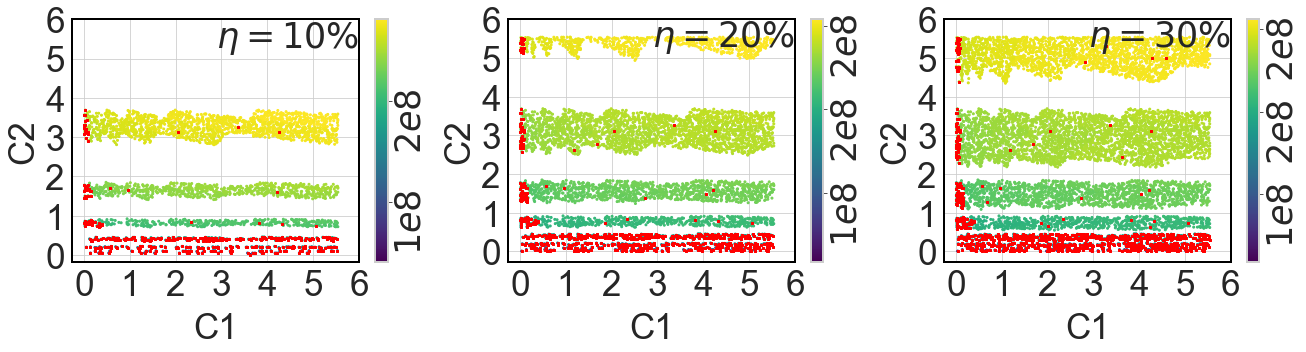

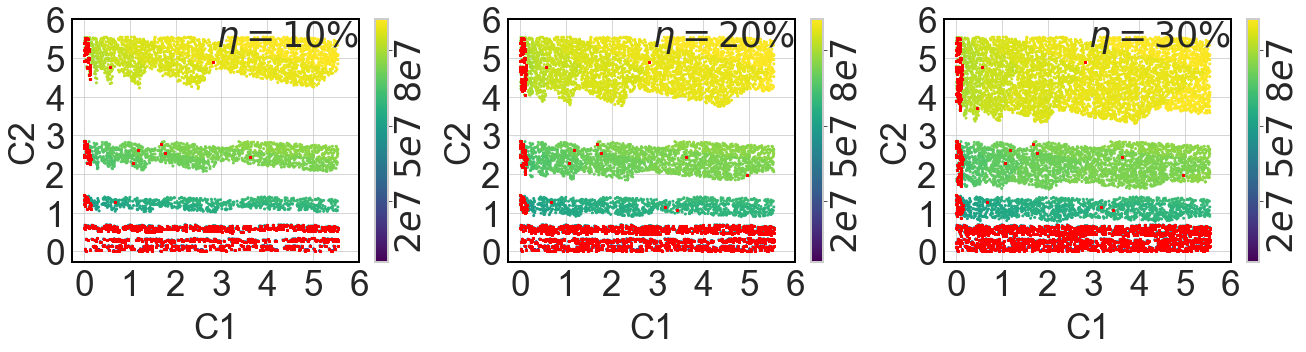

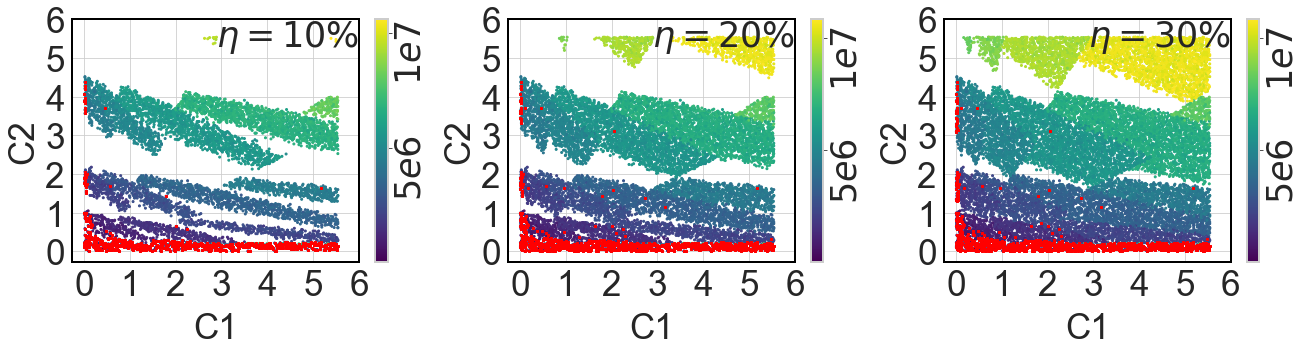

In [ ]:
# for time_path in ["datasets/cloudf48_log_1.01e-04.csv",
#                   "datasets/cloudf48_log_1.02e-02.csv",
#                   "datasets/cloudf48_log_1.02e+00.csv",
#                   ]:
#     plot_slice_threshold(time_path, "c1", "c2")

# for time_path in ["datasets/baryon_density_1.16e+00.csv",
#                   "datasets/baryon_density_1.16e+02.csv",
#                   "datasets/baryon_density_1.16e+04.csv",
#                   ]:
#     plot_slice_threshold(time_path, "c1", "c2")

for time_path in ["datasets/pres-98x1200x1200_9.95e-01.csv",
                  "datasets/pres-98x1200x1200_9.95e+01.csv",
                  "datasets/pres-98x1200x1200_9.95e+03.csv",
                 ]:
    plot_slice_threshold(time_path, "c1", "c2")

In [ ]:

for time_path in [[#"datasets/cloudf48_log_1.00e-06.csv",
                   "datasets/cloudf48_log_1.01e-04.csv",
                   "datasets/cloudf48_log_1.02e-02.csv",
                   "datasets/cloudf48_log_1.02e+00.csv",
                  ],
                  [#"datasets/baryon_density_1.16e-02.csv",
                   "datasets/baryon_density_1.16e+00.csv",
                   "datasets/baryon_density_1.16e+02.csv",
                   "datasets/baryon_density_1.16e+04.csv",
                  ],
                  [#"datasets/pres-98x1200x1200_9.95e-03.csv",
                   "datasets/pres-98x1200x1200_9.95e-01.csv",
                   "datasets/pres-98x1200x1200_9.95e+01.csv",
                   "datasets/pres-98x1200x1200_9.95e+03.csv",]
                 ]:
    plot_slice_error(time_path, "c1", "c2")

## Modeling

In [ ]:
# @timer
def alpha_shape_2d(points, alpha, only_outer=True):
    """
    # https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

In [ ]:
@timer
def search_alpha_shape_2d(points_miss, points_hit, alpha, use_contour=False, special=True):
    # if point_hit, point_hit, then we are searching the error-bounding data points
    # search interval
    s_bin = 0.06
    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=alpha, only_outer=False) # alpha=(np.log10(1/threshold)+.1)
        Contour = []
        for i, j in edges:
            if [points_miss[i][0], points_miss[i][1]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1]])

            if [points_miss[j][0], points_miss[j][1]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 0] >= cx - s_bin) & (points_miss[:, 0] < cx)]
        if len(chunk):
            ## if searching on the not-error-bounding data points, we are finding the upper contour.
            vx.append(chunk[chunk[:, 1] == np.max(chunk[:, 1])][0][0])
            vy.append(chunk[chunk[:, 1] == np.max(chunk[:, 1])][0][1])
            # if searching on the error-bounded data points, we are finding the lower contour.
            # vx.append(chunk[chunk[:, 1] == np.min(chunk[:, 1])][0][0])
            # vy.append(chunk[chunk[:, 1] == np.min(chunk[:, 1])][0][1])
            # vx.append(chunk[0][0])
            # vy.append(chunk[0][1])
    if special:
        for cx in np.arange(6, 0, -1*s_bin):
            cx = np.around(cx, 2)

            chunk = points_miss[(points_miss[:, 0] >= cx - s_bin) & (points_miss[:, 0] < cx)]
            if len(chunk):
                vx.append(chunk[chunk[:, 1] == np.min(chunk[:, 1])][0][0])
                vy.append(chunk[chunk[:, 1] == np.min(chunk[:, 1])][0][1])
        vx.append(vx[0])
        vy.append(vy[0])


    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    for vx_, vy_ in zip(vx, vy):
            if vx_+vy_ < vmin:
                vmin = vx_+vy_
                Vx = vx_
                Vy = vy_

    # find the nearst curve-hit point
    dmin = 2
    dx = 0
    dy = 0
    for px, py in points_hit:
        if np.sqrt((px-Vx)**2 + (py-Vy)**2) < dmin:
            dmin = np.sqrt((px-Vx)**2 + (py-Vy)**2)
            dx = px
            dy = py

    return vx, vy, Vx, Vy, dx, dy

In [ ]:
@timer
def search_alpha_shape_3d(points_miss, points_hit, alpha, use_contour=True, special=True):
    # search interval
    s_bin = 0.2

    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=alpha, only_outer=False)
        Contour = []
        for i, j in edges:
            if [points_miss[i][0], points_miss[i][1], points_miss[i][2]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1], points_miss[i][2]])

            if [points_miss[i][0], points_miss[j][1], points_miss[j][2]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1], points_miss[j][2]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    vz = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 1] >= cx - s_bin) & (points_miss[:, 1] < cx)]
        if len(chunk):
            # vx.append(chunk[0][0])
            # vx.append(chunk[0][1])
            # vx.append(chunk[0][2])
            vx.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][0])
            vy.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][1])
            vz.append(chunk[chunk[:, 2] == np.max(chunk[:, 2])][0][2])

            # vx.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][0])
            # vy.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][1])
            # vz.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][2])
    if special:
        for cx in np.arange(6, 0, -1*s_bin):
            cx = np.around(cx, 2)

            chunk = points_miss[(points_miss[:, 1] >= cx - s_bin) & (points_miss[:, 1] < cx)]
            if len(chunk):
                vx.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][0])
                vy.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][1])
                vz.append(chunk[chunk[:, 2] == np.min(chunk[:, 2])][0][2])
        vx.append(vx[0])
        vy.append(vy[0])
        vz.append(vz[0])


    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    for vx_, vy_, vz_ in zip(vx, vy, vz):
            if vy_+vz_ < vmin:
                vmin = vy_+vz_
                Vx = vx_
                Vy = vy_
                Vz = vz_

    # find the nearest curve-hit point
    dmin = 2
    dx = 0
    dy = 0
    dz = 0
    for px, py, pz in points_hit:
        if np.sqrt((py-Vy)**2 + (pz-Vz)**2) < dmin:
            dmin = np.sqrt((py-Vy)**2 + (pz-Vz)**2)
            dx = px
            dy = py
            dz = pz

    if use_contour:
        return np.array(Contour), vx, vy, vz, Vx, Vy, Vz, dx, dy, dz
    else:
        return vx, vy, vz, Vx, Vy, Vz, dx, dy, dz

In [ ]:
@timer
def search_alpha_shape_4d(points_miss, points_hit, alpha, use_contour=False):
    # search interval
    s_bin = 0.03

    # construct a 2d alpha_shape and find the contour
    if use_contour:
        edges = alpha_shape_2d(np.array(points_miss[:, [-2,-1]]), alpha=alpha, only_outer=False)
        Contour = []
        for i, j in edges:
            if [points_miss[i][2], points_miss[i][3]] not in Contour:
                Contour.append([points_miss[i][0], points_miss[i][1], points_miss[i][2], points_miss[i][3]])

            if [points_miss[j][2], points_miss[j][3]] not in Contour:
                Contour.append([points_miss[j][0], points_miss[j][1], points_miss[j][2], points_miss[j][3]])

        points_miss = np.array(Contour) # or points_miss
    else:
        points_miss = np.array(points_miss) # or points_miss

    vx = []
    vy = []
    vz = []
    vh = []
    for cx in np.arange(0.00, 6, s_bin):
        cx = np.around(cx, 2)

        chunk = points_miss[(points_miss[:, 2] >= cx - s_bin) & (points_miss[:, 2] < cx)]
        if len(chunk):
            # vx.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][0])
            # vy.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][1])
            # vz.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][2])
            # vh.append(chunk[chunk[:, 3] == np.max(chunk[:, 3])][0][3])
            vx.append(chunk[chunk[:, 3] == np.min(chunk[:, 3])][0][0])
            vy.append(chunk[chunk[:, 3] == np.min(chunk[:, 3])][0][1])
            vz.append(chunk[chunk[:, 3] == np.min(chunk[:, 3])][0][2])
            vh.append(chunk[chunk[:, 3] == np.min(chunk[:, 3])][0][3])

    # find the lower left corner of curve-missed points
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    Vh = 0
    for vx_, vy_, vz_, vh_ in zip(vx, vy, vz, vh):
            if vz_+vh_ < vmin:
                vmin = vz_+vh_
                Vx = vx_
                Vy = vy_
                Vz = vz_
                Vh = vh_

    dmin = 2
    dx = 0
    dy = 0
    dz = 0
    dh = 0
    for px, py, pz, ph in points_hit:
        if np.sqrt((pz-Vz)**2 + (ph-Vh)**2) < dmin:
            dmin = np.sqrt((pz-Vz)**2 + (ph-Vh)**2)
            dx = px
            dy = py
            dz = pz
            dh = ph

    return vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh

In [ ]:
@timer
def search_convex_hull_2d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1]] not in Hull:
            # Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    for vx_, vy_, in zip(vx, vy):
        if vx_+vy_ < vmin:
            vmin = vx_+vy_
            Vx = vx_
            Vy = vy_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])

    return vx, vy, Vx, Vy

In [ ]:
@timer
def search_convex_hull_3d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    vz = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1], points[hull.vertices[vid],2]] not in Hull:
        #     Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])
        vz.append(points[hull.vertices[vid],2])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    for vx_, vy_, vz_ in zip(vx, vy, vz):
        if vy_+vz_ < vmin:
            vmin = vy_+vz_
            Vx = vx_
            Vy = vy_
            Vz = vz_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])
    vz.append(points[hull.vertices[0],2])

    return vx, vy, vz, Vx, Vy, Vz

In [ ]:
@timer
def search_convex_hull_4d(points):
    """
    Constructing the convex hull and search the bottom left corner.
    """
    # Computing the convex hull
    hull = ConvexHull(points, incremental=False)
    vx = []
    vy = []
    vz = []
    vh = []
    # Hull = []
    for vid in np.arange(len(hull.vertices)):
        # if [points[hull.vertices[vid],0], points[hull.vertices[vid],1], points[hull.vertices[vid],2]] not in Hull:
        #     Hull.append([points[hull.vertices[vid],0], points[hull.vertices[vid],1]])
        vx.append(points[hull.vertices[vid],0])
        vy.append(points[hull.vertices[vid],1])
        vz.append(points[hull.vertices[vid],2])
        vh.append(points[hull.vertices[vid],3])

    # find the lower left corner
    vmin = 99
    Vx = 0
    Vy = 0
    Vz = 0
    Vh = 0
    for vx_, vy_, vz_, vh_ in zip(vx, vy, vz, vh):
        if vz_+vh_ < vmin:
            vmin = vz_+vh_
            Vx = vx_
            Vy = vy_
            Vz = vz_
            Vh = vh_

    # for printing purpose only
    vx.append(points[hull.vertices[0],0])
    vy.append(points[hull.vertices[0],1])
    vz.append(points[hull.vertices[0],2])
    vh.append(points[hull.vertices[0],3])

    return vx, vy, vz, vh, Vx, Vy, Vz, Vh

In [ ]:
def model_2d(Threshold, Time_paths):
    for t in range(0, 3): #len(Threshold)
        threshold = Threshold[t]

        # DATASETS
        for k in range(0, 3):
            time_path = Time_paths[k]
            dname = time_path.split("/")[1]
            data0 = pd.read_csv(time_path).drop_duplicates()
            reqerr = data0.Requested_tolerance.values[0]

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            points1 = np.vstack([c0, c1]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            points2 = np.vstack([c0, c1]).T

            vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, iosize, maxerr))

            vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=False, special=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, iosize, maxerr))

            vx, vy, Vx, Vy = search_convex_hull_2d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, Vx, Vy, iosize, maxerr))

# %prun
# model_2d(Threshold, Time_paths_lvl2)

In [ ]:
# For not-error-bounded data points searching:
# be sure to mention: 1) some datasets require tuning on alpha (baryon_density: alpha=(np.log10(1/threshold)+.1)), others=alpha=(np.log10(1/threshold)+.1)/5;
#                     2) some require larger dmin when searching viable combinations precipf48_log_3.58e-04.
def model_3d(Threshold, Time_paths):
    for k in range(0, len(Time_paths)):
        # DATASETS
        # for k in range(0, 1):
        time_path = Time_paths[k]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        try:
            # baseline
            iosize_b = np.max(data0.Total_retrieve_size[(data0.c0 > 5) & (data0.c1 > 5) & (data0.c2 > 5)].values)
            maxerr_b = np.max(data0.MaxErr[(data0.c0 > 5) & (data0.c1 > 5) & (data0.c2 > 5)].values)
            # print(iosize_b, maxerr_b)

        except:
            continue

        for t in range(0, len(Threshold)): #len(Threshold)
            threshold = Threshold[t]
            # print(dname, threshold)

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
            points1 = np.vstack([c0, c1, c2]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
            points2 = np.vstack([c0, c1, c2]).T

            # find the best in convex hull
            vx, vy, vz, Vx, Vy, Vz = search_convex_hull_3d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{},baseline,{},{}".format(dname, reqerr, threshold, Vx, Vy, Vz, iosize, maxerr, iosize_b, maxerr_b))
            # ax1.plot(Vy, Vz, '*',  color="green", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_CH")

            # _, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=True)
            # iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            # maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            # print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{},baseline,{},{}".format(dname, reqerr, threshold, dx, dy, dz, iosize, maxerr, iosize_b, maxerr_b))
            # # ax1.plot(Vy, Vz, '*',  color="red", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_AS_EBF")

            # find the best in alpha shape
            _, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},Total_retrieve_size,{},Compression_error,{},baseline,{},{}".format(dname, reqerr, threshold, dx, dy, dz, iosize, maxerr, iosize_b, maxerr_b))
            # ax1.plot(dy, dz, '*',  color="blue", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_AS_NEBF")

# Threshold = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10,
#              0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.20,
#              0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30,
#              0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40]



# model_3d([.001, .01, .1, .3, .5, .7, .9],['datasets/cloudf48_log_1.01e-04.csv', 'datasets/cloudf48_log_1.02e-02.csv', 'datasets/cloudf48_log_1.02e+00.csv',])

In [ ]:
matplotlib.__version__

'3.5.3'

/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_92514/1616982109.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 360x288 with 0 Axes>

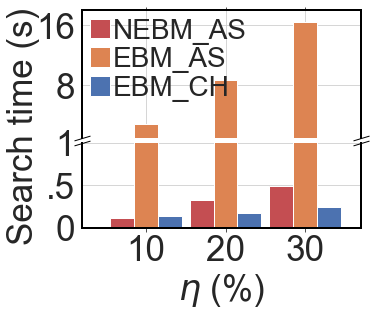

In [ ]:
plt.rcParams["figure.figsize"] = [5, 4]
fig = plt.figure()

# ax = fig.add_subplot(1, 1, 1)
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 2]), sharex=True)
fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# # cloud48, 1e-5
# ch_3d = [0.20, 0.18, 0.23]
# as_ebm = [4.0599, 9.7309, 15.8389]
# as_nebm = [0.1342, 0.3056, 0.4803]

# # cloud48, 1e-3
# ch_3d = [0.11, 0.15, 0.21]
# as_ebm = [2.4610, 5.8477, 11.3967]
# as_nebm = [0.0886, 0.2077, 0.3342]

# cloud48, 1e-1
ch_3d = [0.14, 0.18, 0.24]
as_ebm = [2.7553, 8.6763, 16.3859]
as_nebm = [0.1154, 0.3334, 0.4937]

# ax.plot(np.arange(3), as_nebm, "-*", linewidth=3, markersize=10, color=current_palette[3], label="NEBM_AS")
# ax.plot(np.arange(3), as_ebm,  "-*", linewidth=3, markersize=10, color=current_palette[1], label="EBM_AS")
# ax.plot(np.arange(3), ch_3d,   "-*", linewidth=3, markersize=10, color=current_palette[0], label="EBM_CH")
ax1.bar(np.arange(3),    as_nebm, width=.3, color=current_palette[3], label="NEBM_AS")
ax1.bar(np.arange(3)+.3, as_ebm,  width=.3, color=current_palette[1], label="EBM_AS")
ax1.bar(np.arange(3)+.6, ch_3d,   width=.3, color=current_palette[0], label="EBM_CH")

ax2.bar(np.arange(3),    as_nebm, width=.3, color=current_palette[3], label="NEBM_AS")
ax2.bar(np.arange(3)+.3, as_ebm,  width=.3, color=current_palette[1], label="EBM_AS")
ax2.bar(np.arange(3)+.6, ch_3d,   width=.3, color=current_palette[0], label="EBM_CH")

ax2.set_xlabel(r'$\eta$ (%)', fontsize=fontsize)
ax1.set_ylabel('Search time (s)', fontsize=fontsize)
ax1.yaxis.set_label_coords(-0.15,.09)

ax2.set_xticks([0+.3, 1+.3, 2+.3]);
ax2.set_xticklabels(["10", "20", "30"], fontsize=fontsize, rotation=0);
ax2.set_xlim((-.5, 3))

ax1.set_ylim(1, 18)  # outliers only
ax2.set_ylim(0, 1)  # most of the data

ax1.set_yticks([8, 16], fontsize=fontsize);
ax1.set_yticklabels([8, 16], fontsize=fontsize);
ax2.set_yticks([0, .5, 1], fontsize=fontsize);
ax2.set_yticklabels(["0", ".5", "1"], fontsize=fontsize);

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.spines["bottom"].set_color("black")
ax1.spines["top"].set_color("black")
ax1.spines["right"].set_color("black")
ax1.spines["left"].set_color("black")

ax2.spines["bottom"].set_color("black")
ax2.spines["top"].set_color("black")
ax2.spines["right"].set_color("black")
ax2.spines["left"].set_color("black")

d = .3  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=16, linewidth=3,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

# fig.tight_layout()
fig.show()
ax1.legend(frameon=False, fancybox=False, facecolor="white", ncol=1, bbox_to_anchor=(-.03, 1.07), loc='upper left', fontsize=fontsize*.8, handletextpad=.1, handlelength=.7, borderpad=.1, labelspacing=.1, columnspacing=.1)
plt.savefig("cloud48_1e-1_time.pdf", dpi="figure", bbox_inches="tight", format="pdf")

In [ ]:
def model_4d(Threshold, Time_paths):
    for t in range(0, 3): #len(Threshold)
        threshold = Threshold[t]

        # DATASETS
        for k in range(0, 3):
            time_path = Time_paths[k]
            dname = time_path.split("/")[1]
            data0 = pd.read_csv(time_path).drop_duplicates()
            reqerr = data0.Requested_tolerance.values[0]

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
            c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c3.values
            points1 = np.vstack([c0, c1, c2, c3]).T

            c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
            c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
            c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
            c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c3.values
            points2 = np.vstack([c0, c1, c2, c3]).T

            # print(dname, threshold, data0.Requested_tolerance.values[0])

            vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, dh, iosize, maxerr))

            vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=False)
            iosize = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz) & (data0.c3 == dh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, dx, dy, dz, dh, iosize, maxerr))

            vx, vy, vz, vh, Vx, Vy, Vz, Vh = search_convex_hull_4d(points1)
            iosize = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz) & (data0.c3 == Vh)].values[0]
            maxerr = data0.MaxErr[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz) & (data0.c3 == Vh)].values[0]
            print("dname,{},reqerr,{},threshold,{},c0,{},c1,{},c2,{},c3,{},Total_retrieve_size,{},Compression_error,{}".format(dname, reqerr, threshold, Vx, Vy, Vz, Vh, iosize, maxerr))

# %prun
# model_4d(Threshold, Time_paths_lvl4)

In [ ]:
# # 2d plot
# # for Time_paths_lvl2
# for t in range(0, 1): #len(Threshold)
#     # threshold = Threshold[5]
#     threshold = 0.03
#     plt.rcParams["figure.figsize"] = [15, 5]
#     fig = plt.figure()

#     # DATASETS
#     for k in range(0, len(Time_paths_lvl2)):
#         time_path = Time_paths_lvl2[k]
#         dname = time_path.split("/")[1]
#         data0 = pd.read_csv(time_path).drop_duplicates()
#         reqerr = data0.Requested_tolerance.values[0]
#         print(threshold, reqerr)

#         ax1 = fig.add_subplot(1, 3, k+1)
#         c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
#         c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
#         trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].Total_retrieve_size.values
#         img1 = ax1.scatter(c0, c1, color="#a1d99b", alpha=1, s=10)
#         points1 = np.vstack([c0, c1]).T

#         c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
#         c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
#         ax1.scatter(c0, c1, color="#fc9272", alpha=1, s=10)
#         points2 = np.vstack([c0, c1]).T

#         # vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
#         vx, vy, Vx, Vy, dx, dy = search_alpha_shape_2d(points2, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
#         ax1.plot(vx, vy, '-*', color="#de2d26", lw=2, label="Alpha shape")
#         ax1.plot(Vx, Vy, '*',  color="#de2d26",       markerfacecolor="green", markersize=15, label="I/O_MIN_AS")
#         ax1.plot(dx, dy, '*',  color="#de2d26", lw=2, markerfacecolor="blue", markersize=15, label="I/O_MIN_AS")

#         # find the best in convex hull
#         vx, vy, Vx, Vy = search_convex_hull_2d(points1)
#         ax1.plot(vx, vy, '-*',color="green", lw=2, label="Convex hull")
#         ax1.plot(Vx, Vy, '*',  color="green", lw=2, markerfacecolor="white", markersize=15, label="I/O_MIN_CH")

#         # ax1.set_title(dname)
#         ax1.set_xlabel('C0', labelpad=10, fontsize=20)
#         ax1.set_ylabel('C1', labelpad=5, fontsize=20)
#         ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
#         ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
#         ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
#         ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

#         ax1.spines["bottom"].set_color("black")
#         ax1.spines["top"].set_color("black")
#         ax1.spines["right"].set_color("black")
#         ax1.spines["left"].set_color("black")

#     fig.tight_layout()
#     fig.show()
#     fig.legend(frameon=False, fancybox=False, ncol=2, bbox_to_anchor=(.5, 1), loc='center', fontsize=18, columnspacing=0.9)
#     # plt.savefig("{}_contour.png".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="png")

In [ ]:
Time_paths_lvl3

['datasets/baryon_density_1.16e+04_lvl3.csv',
 'datasets/cloudf48_log_1.02e+00_lvl3.csv',
 'datasets/pres-98x1200x1200_9.95e+03_lvl3.csv']

<function search_convex_hull_2d at 0x29c1ac280>:0.0006 seconds
<function search_convex_hull_2d at 0x29c1ac280>:0.0007 seconds


/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_41678/1780302798.py:143: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_41678/1780302798.py:143: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<function search_convex_hull_2d at 0x29c1ac280>:0.0009 seconds


/var/folders/3w/rn_9fvnn1g975d3mgwhr4m3m0000gn/T/ipykernel_41678/1780302798.py:143: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


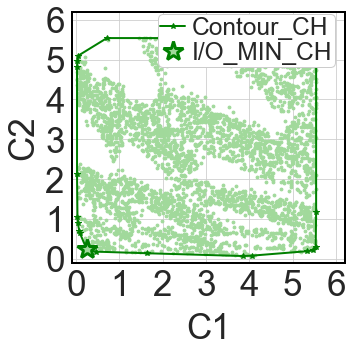

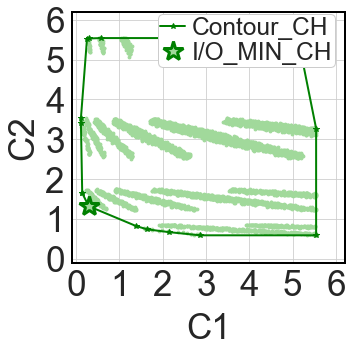

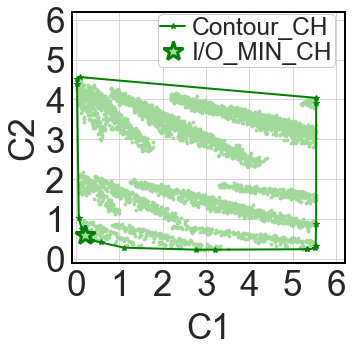

In [ ]:
# 3d plot
# Time_paths = ['datasets/cloudf48_log_1.01e-04.csv',
#               'datasets/pres-98x1200x1200_9.95e-01.csv',
#               'datasets/baryon_density_1.16e+00.csv']

Time_paths = Time_paths_lvl3

# Time_paths = ["datasets/cloudf48_log_1.01e-04.csv",
#              "datasets/cloudf48_log_1.02e-02.csv",
#              "datasets/cloudf48_log_1.02e+00.csv",
#             ]

# Threshold = [0.03] #  0.03, 0.06, 0.09 0.2, 0.3, 0.4, 0.5, 0.6
threshold = 0.03

# DATASETS
for k in range(0, 3): #len(Time_paths)

    plt.rcParams["figure.figsize"] = [5, 5]
    fig = plt.figure()

    time_path = Time_paths[k]
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    ax1 = fig.add_subplot(1, 1, 1) # convex hull
    # ax2 = fig.add_subplot(1, 1, 1) # alpha shape

    # Code snippet to create inset axes.
    # axis is the surrounding axis into which the inset axis will be added
    # Create an inset axis in the bottom right corner
    axin = ax2.inset_axes([.2, .18, 0.48, 0.48])
    axin.set_facecolor("#f0f0f0")
    # ===============================================================================================
    c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
    c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
    c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
    # points1 = np.vstack([c0, c1, c2]).T
    points1 = np.vstack([c1, c2]).T

    ax1.scatter(c1, c2, color="#a1d99b", alpha=1, s=8)
    ax2.scatter(c1, c2, color="#a1d99b", alpha=1, s=8)
    axin.scatter(c1, c2, color="#a1d99b", alpha=1, s=16)

    # find the best in convex hull
    vy, vz, Vy, Vz = search_convex_hull_2d(np.vstack([c1, c2]).T)
    # vx, vy, vz, Vx, Vy, Vz = search_convex_hull_3d(points1)
    ax1.plot(vy, vz, '-*', color="green", lw=2, label="Contour_CH")
    ax1.plot(Vy, Vz, '*',  color="green", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_CH")

    # vy, vz, Vy, Vz, dy, dz = search_alpha_shape_2d(np.vstack([c1, c2]).T, np.vstack([c1, c2]).T, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=True) #
    # # _, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=True)
    # ax1.plot(vy, vz, '-*', color="green", lw=2, label="Contour_AS")
    # ax1.plot(Vy, Vz, '*',  color="green", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_AS")

    # ===============================================================================================
    # c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
    # c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
    # c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
    # points2 = np.vstack([c1, c2]).T

    # ax2.scatter(c1, c2, color="#fc9272", s=8)
    # axin.scatter(c1, c2, color="#fc9272", s=16)

    # # _, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
    # # ax2.plot(dy, dz, '*',  color="blue", lw=3, markeredgewidth=3, markerfacecolor="#a1d99b", markersize=20, label="I/O_MIN_AS_NEBF")

    # vy, vz, Vy, Vz, dy, dz = search_alpha_shape_2d(points2, points1, alpha=(np.log10(1/threshold)+.1)*5, use_contour=True, special=True) #
    # ax2.plot(vy, vz, '-*', color="#de2d26", lw=2, label="Contour_AS")

    # # print(vx, vy, vz)
    # ax2.plot(Vy, Vz, 'P',  color="#de2d26",      markerfacecolor="white", markeredgewidth=3, markersize=15, label="Optimum_AS") # ,
    # ax2.plot(dy, dz, '*',  color="#de2626", lw=3,markerfacecolor="#a1d99b", markeredgewidth=3, markersize=20, label="I/O_MIN_AS")

    # # # axin.plot(vy, vz, 'o',  color="#de2d26", markersize=5, lw=2,  )
    # axin.plot(vy, vz, '-*', color="#de2d26", lw=2,)
    # axin.plot(Vy, Vz, 'P',  color="#de2d26",      markerfacecolor="white", markeredgewidth=3, markersize=15) # ,
    # axin.plot(dy, dz, '*',  color="#de2626", lw=3,markerfacecolor="#a1d99b", markeredgewidth=3, markersize=20)

    if k==0:
        axin.set_xlim(-.1, .5)
        axin.set_ylim(-.1, .5)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0, 0.25, 0.5, 0.75, 1])
    elif k ==1:
        axin.set_xlim(-.1, 0.5)
        axin.set_ylim(-.1, 1.5)
        # axin.set_xlim(0.7, 1.7)
        # axin.set_ylim(0.5, 1.5)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0.25, 0.5, 0.75, 1, 1.25])
    elif k==2:
        axin.set_xlim(-.1, 0.7)
        axin.set_ylim(-.1, 0.7)
        # axin.set_xlim(0, 1)
        # axin.set_ylim(0, 1)
        # axin.set_xticks([0, 0.25, 0.5, 0.75, 1])
        # axin.set_yticks([0, 0.25, 0.5, 0.75, 1])

    axin.set_xticks([])
    axin.set_yticks([])

    ax2.indicate_inset_zoom(axin, alpha=1, edgecolor="k")

    axin.spines["bottom"].set_color("black")
    axin.spines["top"].set_color("black")
    axin.spines["right"].set_color("black")
    axin.spines["left"].set_color("black")

    # ax1.set_title(dname)
    ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    # ax2.set_title(dname)
    ax2.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    ax2.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    ax2.set_xticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_yticks([0, 1, 2, 3, 4, 5, 6]);
    ax2.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
    ax2.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

    ax2.set_xlim(-.1, 6.5)
    ax2.set_ylim(-.1, 6.5)
    ax1.set_xlim(-.1, 6.2)
    ax1.set_ylim(-.1, 6.2)

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()

    lgnd = ax1.legend(frameon=True, fancybox=True, facecolor="white", ncol=1, bbox_to_anchor=(1.01, 1.04), loc='upper right', fontsize=fontsize*.7, handletextpad=.3, handlelength=1, borderpad=.1, labelspacing=.1, columnspacing=.1)
    lgnd.get_frame().set_alpha(None)
    # lgnd = ax2.legend(frameon=True, fancybox=True, facecolor="white", ncol=1, bbox_to_anchor=(1.01, 1.04), loc='upper right', fontsize=fontsize*.7, handletextpad=.3, handlelength=1, borderpad=.1, labelspacing=.1, columnspacing=.1)
    # lgnd.get_frame().set_alpha(None)

    plt.savefig("{}_search_CH_EBF.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")

In [ ]:
# 4d plot
for t in range(0, 1): #len(Threshold)
    threshold = Threshold[t]

    plt.rcParams["figure.figsize"] = [15*1.2, 5*1.2]
    fig = plt.figure()

    # DATASETS
    for k in range(0, 3):
        time_path = Time_paths_lvl4[k]
        dname = time_path.split("/")[1]
        data0 = pd.read_csv(time_path).drop_duplicates()
        reqerr = data0.Requested_tolerance.values[0]

        ax1 = fig.add_subplot(1, 3, k+1)
        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
        c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c3.values
        trsdata = data0[(data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].Total_retrieve_size.values
        img1 = ax1.scatter(c2, c3, c=trsdata, cmap="viridis", alpha=1, s=4)
        points1 = np.vstack([c0, c1, c2, c3]).T

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
        c3 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c3.values
        ax1.scatter(c2, c3, color=current_palette[3], alpha=1, s=4)
        points2 = np.vstack([c0, c1, c2, c3]).T

        vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True)
        ax1.plot(dz, dh, 's', color=current_palette[2], markersize=10)
        ax1.plot(Vz, Vh, 's', color=current_palette[2], markerfacecolor="None", markersize=10)
        ax1.plot(vz, vh, 'o', color=current_palette[2], markerfacecolor="None")
        ax1.plot(vz, vh, '-', color=current_palette[2], lw=2)

        # find the best in curve-miss points
        vx, vy, vz, vh, Vx, Vy, Vz, Vh, dx, dy, dz, dh = search_alpha_shape_4d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=False)
        ax1.plot(dz, dh, '*', color=current_palette[3], markersize=10)
        ax1.plot(Vz, Vh, '*', color=current_palette[3], markerfacecolor="None", markersize=10)
        ax1.plot(vz, vh, 'o', color=current_palette[3], markerfacecolor="None")
        ax1.plot(vz, vh, '--', color=current_palette[3], lw=2)

        # find the best in convex hull
        vx, vy, vz, vh, Vx, Vy, Vz, Vh = search_convex_hull_4d(points1)
        ax1.plot(Vz, Vh, '*', color=current_palette[4], markersize=10)
        # ax1.plot(vz, vh, 'ko')

        ax1.set_title(dname)
        ax1.set_xlabel('C2', labelpad=10, fontsize=20)
        ax1.set_ylabel('C3', labelpad=5, fontsize=20)
        ax1.set_xticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_yticks([0, 1, 2, 3, 4, 5, 6]);
        ax1.set_xticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);
        ax1.set_yticklabels([0, 1, 2, 3, 4, 5, 6], fontsize=fontsize);

        ax1.spines["bottom"].set_color("black")
        ax1.spines["top"].set_color("black")
        ax1.spines["right"].set_color("black")
        ax1.spines["left"].set_color("black")

    fig.tight_layout()
    fig.show()

In [ ]:
Time_paths = ["datasets/cloudf48_log_1.01e-04.csv",
             "datasets/cloudf48_log_1.02e-02.csv",
             "datasets/cloudf48_log_1.02e+00.csv",
            ]

Time_paths = ["datasets/baryon_density_1.16e+00.csv",
                  "datasets/baryon_density_1.16e+02.csv",
                  "datasets/baryon_density_1.16e+04.csv",
                  ]

# Time_paths = ["datasets/pres-98x1200x1200_9.95e-01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+01.csv",
#                   "datasets/pres-98x1200x1200_9.95e+03.csv",]

# Threshold = [0.03, 0.06, 0.09, 0.3, 0.6, 0.9,] #  0.03, 0.06, 0.09 0.2, 0.3, 0.4, 0.5, 0.6
Threshold = [0.1, 0.2, 0.3,] #  0.4, 0.5, 0.6, 0.7, 0.8, 0.9

plt.rcParams["figure.figsize"] = [15, 5]
fig = plt.figure()

for k in range(0, len(Time_paths)):
    # DATASETS
    time_path = Time_paths[k]
    dname = time_path.split("/")[1]
    data0 = pd.read_csv(time_path).drop_duplicates()
    reqerr = data0.Requested_tolerance.values[0]

    ax1 = fig.add_subplot(1, len(Time_paths), k+1)

    DY = []
    DZ = []
    VY = []
    VZ = []
    iosize_AS = []
    iosize_CH = []
    maxerr_AS = []
    maxerr_CH = []

    for t in range(0, len(Threshold)): #len(Threshold)
        threshold = Threshold[t]

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr < reqerr)].c2.values
        points1 = np.vstack([c0, c1, c2]).T

        c0 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c0.values
        c1 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c1.values
        c2 = data0[ (data0.estimated_error >= reqerr*(1-threshold))&(data0.MaxErr > reqerr)].c2.values
        points2 = np.vstack([c0, c1, c2]).T

        # ax1 = fig.add_subplot(1, len(Threshold), t+1)

        ## search with NEBF
        contour, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points2, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=False)
        print(dx, dy, dz)

        # # search with contour of EBF
        contour, vx, vy, vz, Vx, Vy, Vz, dx, dy, dz = search_alpha_shape_3d(points1, points1, alpha=(np.log10(1/threshold)+.1), use_contour=True, special=True)
        print(dx, dy, dz)
        # iosize_as = data0.Total_retrieve_size[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
        # maxerr_as = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
        # ax1.plot(dy, dz, '*',  color="blue", markersize=20, markerfacecolor="None", label="Lowest I/O - AlphaContour")
        # DY.append(dy)
        # DZ.append(dz)
        # iosize_AS.append(iosize_as)
        # maxerr_AS.append(maxerr_as)

        # search with convex hull of error-bounded data points
        vx, vy, vz, Vx, Vy, Vz = search_convex_hull_3d(points1)
        print(Vx, Vy, Vz)
        # iosize_ch = data0.Total_retrieve_size[(data0.c0 == Vx) & (data0.c1 == Vy) & (data0.c2 == Vz)].values[0]
        # maxerr_ch = data0.MaxErr[(data0.c0 == dx) & (data0.c1 == dy) & (data0.c2 == dz)].values[0]
        # ax1.plot(Vy, Vz, '*',  color="#d95f0e", markersize=20, label="Lowest I/O - ConvexHull")
        # VY.append(Vy)
        # VZ.append(Vz)
        # iosize_CH.append(iosize_ch)
        # maxerr_CH.append(maxerr_ch)

    # print(iosize_AS)
    # print(iosize_CH)
    # print(maxerr_AS)
    # print(maxerr_CH)
    # ax1.plot(DY, DZ, '-*',  color="blue", markersize=20, markerfacecolor="None", label="Lowest I/O - AlphaContour")
    # ax1.plot(VY, VZ, '-*',  color="#d95f0e", markersize=20, label="Lowest I/O - ConvexHull")

    # ax1.set_xlabel('C1', labelpad=10, fontsize=fontsize)
    # ax1.set_ylabel('C2', labelpad=5, fontsize=fontsize)
    # # ax1.set_xticks([0, 1, 2, 3]);
    # # ax1.set_yticks([0, 1, 2, 3]);
    # # ax1.set_xticklabels([0, 1, 2, 3], fontsize=fontsize);
    # # ax1.set_yticklabels([0, 1, 2, 3], fontsize=fontsize);

    # ax1.spines["bottom"].set_color("black")
    # ax1.spines["top"].set_color("black")
    # ax1.spines["right"].set_color("black")
    # ax1.spines["left"].set_color("black")

    # ax1.set_title("{},{}".format(iosize_as, iosize_ch))

    # fig.tight_layout()
    # fig.show()
    # fig.legend(frameon=False, fancybox=False, ncol=2, bbox_to_anchor=(.52, 1.1), loc='center', fontsize=20, borderpad=.1, labelspacing=.5)

    # plt.savefig("{}_search_contour_3d.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), bbox_inches='tight', format="pdf")

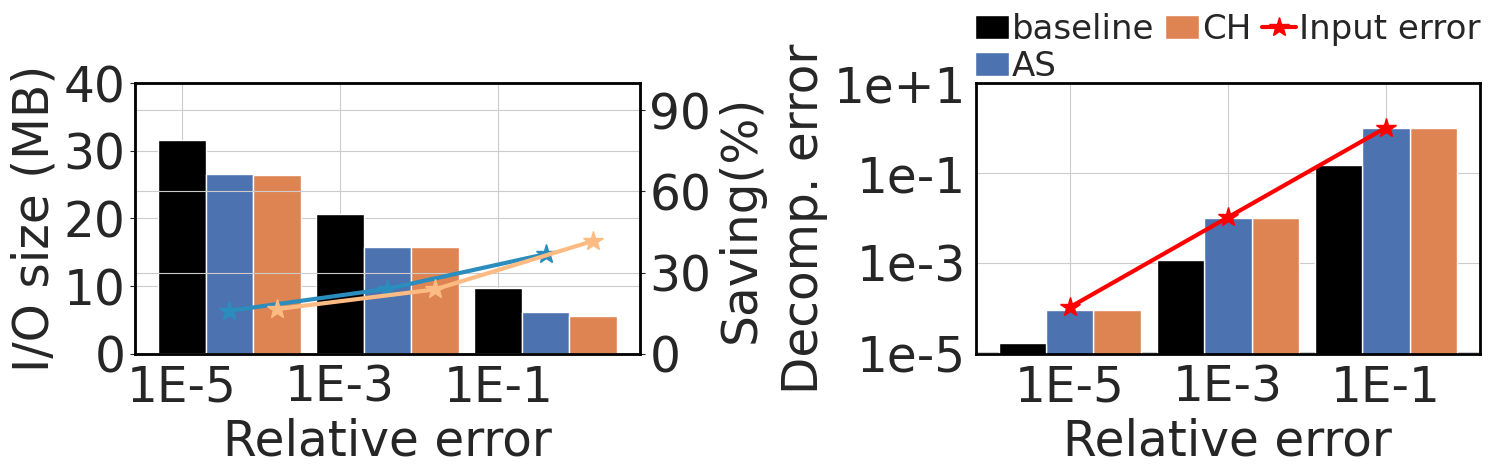

In [8]:
# I/O and MaxErr evaluation
# dnames = ["cloudf48", "precipf48", "qgraupf48", "qicef48", "pres", "qc", "qg-", "qi-",  "baryon_density", "dark_matter_density", "temperature", "velocity_x"]
dnames = ["cloudf48"]
relative_error = [1e-5, 1e-3, 1e-1]
# relative_error = [1e-5]
data_as = pd.read_csv("as_optimization.csv")
data_ch = pd.read_csv("ch_optimization.csv")
data_em = pd.read_csv("emgard.csv")

threshold = 0.05

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

for i in np.arange(0, len(dnames)):
    plt.rcParams["figure.figsize"] = [15, 5] # [7, 5] for ax1
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(121) # io
    ax2 = fig1.add_subplot(122) # max error
    dname = dnames[i]

    abs             = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].abserr.values
    io_baseline     = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].baseline_io.values
    io_as           = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].Total_retrieve_size.values
    io_ch           = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Total_retrieve_size.values

    maxerr_baseline = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].baseline_maxerr.values
    maxerr_as       = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Compression_error.values
    maxerr_ch       = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Compression_error.values
    maxerr_em       = data_em[data_em.dname.str.contains(dname)].Compression_error.values
    ax1.bar(np.arange(len(io_baseline)), io_baseline/1024/1024, width=0.3, color="black")
    ax1.bar(np.arange(len(io_as))+0.3,   io_as/1024/1024,       width=0.3, color=current_palette[0])
    ax1.bar(np.arange(len(io_ch))+0.6,   io_ch/1024/1024,       width=0.3, color=current_palette[1])
    axs = ax1.twinx()

    axs.plot(np.arange(len(io_as))+.3, (io_baseline - io_as)/io_baseline*100, lw=3, marker="*", markersize=15, color="#2b8cbe", label="AS_sav")
    axs.plot(np.arange(len(io_as))+.6, (io_baseline - io_ch)/io_baseline*100, lw=3, marker="*", markersize=15, color="#fdbb84", label="CH_sav")
    # print("dname:{},as:{} ".format(dname, (io_baseline - io_as)/io_baseline*100))
    # print("dname:{},ch:{} ".format(dname, (io_baseline - io_ch)/io_baseline*100))

    axs.bar([0], [0], width=0.3, color="black",label="BL")
    axs.bar([0], [0], width=0.3, color=current_palette[1], label="CH")
    axs.bar([0], [0], width=0.3, color=current_palette[0], label="AS")

    ax2.bar(np.arange(len(maxerr_ch))+0.6,   maxerr_ch,          width=0.3, color=current_palette[1], label="CH")
    ax2.bar(np.arange(len(maxerr_as))+0.3,   maxerr_as,          width=0.3, color=current_palette[0], label="AS")
    # ax2.bar(np.arange(len(maxerr_em))+0.2,   np.flip(maxerr_em), width=0.2, color="grey", label="EM")
    ax2.bar(np.arange(len(maxerr_baseline)), maxerr_baseline,    width=0.3, color="black", label="baseline")
    ax2.plot(np.arange(len(maxerr_baseline))+.3, abs, lw=3, marker="*", markersize=15, color="red", label="Input error")

    ax1.set_ylim((0, np.max(io_baseline/1024/1024)*1.2))
    axs.set_ylim((0, 100))
    ax1.set_xticks(np.arange(len(io_as)))
    ax1.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize)
    ax2.set_xticks(np.arange(len(io_as))+.3)
    ax2.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize)
    axs.set_yticks([0, 30, 60, 90])
    axs.set_yticklabels(["0", "30", "60", "90"], fontsize=fontsize)

    ax2.set_yscale("log")
    if dname == "cloudf48":
        ax1.set_yticks([0, 10, 20, 30, 40]);
        ax1.set_yticklabels(["0", "10", "20", "30", "40"], fontsize=fontsize)
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "precipf48":
        ax1.set_yticks([0, 20, 40, 60])
        ax1.set_yticklabels(["0", "20", "40", "60"], fontsize=fontsize)
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "qgraupf48":
        ax1.set_yticks([0, 20, 40, 60])
        ax1.set_yticklabels(["0", "20", "40", "60"], fontsize=fontsize)
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "qicef48":
        ax1.set_yticks([0, 10, 20, 30]);
        ax1.set_yticklabels(["0", "10", "20", "30"], fontsize=fontsize)
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "pres":
        ax1.set_yticks([0, 50, 100, 150, 200])
        ax1.set_yticklabels(["0", "50", "100", "150", "200"], fontsize=fontsize)
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "qc":
        ax1.set_yticks([0, 30, 60, 90])
        ax1.set_yticklabels(["0", "30", "60", "90"], fontsize=fontsize)
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "qg-":
        ax1.set_yticks([0, 20, 40, 60])
        ax1.set_yticklabels(["0", "20", "40", "60"], fontsize=fontsize)
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "qi-":
        ax1.set_yticks([0, 20, 40, 60, 80])
        ax1.set_yticklabels(["0", "20", "40", "60", "80"], fontsize=fontsize)
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "baryon_density":
        ax1.set_yticks([0, 10, 20, 30])
        ax1.set_yticklabels(["0", "10", "20", "30"], fontsize=fontsize)
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "dark_matter_density":
        ax1.set_yticks([0, 50, 100, 150])
        ax1.set_yticklabels(["0", "50", "100", "150"], fontsize=fontsize)
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "temperature":
        ax1.set_yticks([0, 50, 100, 150])
        ax1.set_yticklabels(["0", "50", "100", "150"], fontsize=fontsize)
        ax2.set_yticks([1e1, 1e3, 1e5, 1e7])
        ax2.set_yticklabels(["1e+1", "1e+3", "1e+5", "1e+7"], fontsize=fontsize)
    if dname == "velocity_x":
        ax1.set_yticks([0, 60, 120, 180])
        ax1.set_yticklabels(["0", "60", "120", "180"], fontsize=fontsize)
        ax2.set_yticks([1e2, 1e4, 1e6, 1e8])
        ax2.set_yticklabels(["1e+2", "1e+4", "1e+6", "1e+8"], fontsize=fontsize)

    if dname == "baryon_density":
        # inset axes....
        axin = ax1.inset_axes([0.45, 0.25, .5, .4])
        axin.bar(np.arange(len(io_baseline)), io_baseline/1024/1024, width=0.3, color="black")
        axin.bar(np.arange(len(io_as))+0.3,   io_as/1024/1024,       width=0.3, color=current_palette[0])
        axin.bar(np.arange(len(io_ch))+0.6,   io_ch/1024/1024,       width=0.3, color=current_palette[1])
        axin.set_xticks([0.3, 1.3, 2.3])
        axin.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize*.7)

        # # subregion of the original image
        axin.set_xlim(0.8, 2.8)
        axin.set_ylim(1e-3, 2)
        axin.set_yscale("log")
        axin.set_yticks([1e-3, 1e-2, 1e-1, 1e0])
        axin.set_yticklabels(["0.001", "0.01", "0.1", "0"], fontsize=fontsize*.7)
        axin.spines["bottom"].set_color("black")
        axin.spines["top"].set_color("black")
        axin.spines["right"].set_color("black")
        axin.spines["left"].set_color("black")
        ax1.indicate_inset_zoom(axin, edgecolor="black")

    if dname in ["temperature", "dark_matter_density"]:
        # inset axes....
        axin = ax1.inset_axes([0.65, 0.2, .3, .3])
        axin.bar(np.arange(len(io_baseline)), io_baseline/1024/1024, width=0.3, color="black")
        axin.bar(np.arange(len(io_as))+0.3,   io_as/1024/1024,       width=0.3, color=current_palette[0])
        axin.bar(np.arange(len(io_ch))+0.6,   io_ch/1024/1024,       width=0.3, color=current_palette[1])
        axin.set_xticks([0.3, 1.3, 2.3])
        axin.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize*.7)

        # # subregion of the original image
        axin.set_xlim(1.8, 2.8)
        axin.set_ylim(9e-3, 1)
        axin.set_yscale("log")
        axin.set_yticks([1e-2, 1e-1, 1e0])
        axin.set_yticklabels(["0.01", "0.1", "1"], fontsize=fontsize*.7)
        axin.spines["bottom"].set_color("black")
        axin.spines["top"].set_color("black")
        axin.spines["right"].set_color("black")
        axin.spines["left"].set_color("black")
        ax1.indicate_inset_zoom(axin, edgecolor="black")

    if dname in ["qi-", "qc", "qg-", "pres", "velocity_x"]:
        # inset axes....
        axin = ax1.inset_axes([0.65, 0.18, .3, .3])
        axin.bar(np.arange(len(io_baseline)), io_baseline/1024/1024, width=0.3, color="black")
        axin.bar(np.arange(len(io_as))+0.3,   io_as/1024/1024,       width=0.3, color=current_palette[0])
        axin.bar(np.arange(len(io_ch))+0.6,   io_ch/1024/1024,       width=0.3, color=current_palette[1])
        axin.set_xticks([0.3, 1.3, 2.3])
        axin.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize*.7)

        # # subregion of the original image
        axin.set_xlim(1.8, 2.8)
        axin.set_ylim(9e-2, 20)
        axin.set_yscale("log")
        axin.set_yticks([1e-1, 1e0, 1e1])
        axin.set_yticklabels(["0.1", "1", "10"], fontsize=fontsize*.7)
        axin.spines["bottom"].set_color("black")
        axin.spines["top"].set_color("black")
        axin.spines["right"].set_color("black")
        axin.spines["left"].set_color("black")
        ax1.indicate_inset_zoom(axin, edgecolor="black")

    ax1.set_xlabel("Relative error",      fontsize=fontsize)
    ax1.set_ylabel("I/O size (MB)",       fontsize=fontsize)
    axs.set_ylabel("Saving(%)",   fontsize=fontsize)
    ax2.set_xlabel("Relative error",      fontsize=fontsize)
    ax2.set_ylabel("Decomp. error", fontsize=fontsize)
    # ax1.set_title(dname)

    axs.spines["bottom"].set_color("black")
    axs.spines["top"].set_color("black")
    axs.spines["right"].set_color("black")
    axs.spines["left"].set_color("black")

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    # handles, labels = ax1.get_legend_handles_labels()
    # ax1.legend(flip(handles[::-1], 2), flip(labels[::-1], 2), frameon=False, fancybox=False, ncol=3, bbox_to_anchor=(.57, 1.12), loc='center', fontsize=fontsize*0.7, handlelength=1, handletextpad=.1, borderpad=.1, columnspacing=.3, labelspacing=.1)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[::-1], labels[::-1], frameon=False, fancybox=False, ncol=3, bbox_to_anchor=(.5, 1.13), loc='center', fontsize=fontsize*0.7, handlelength=1, handletextpad=.1, borderpad=.1, columnspacing=.3, labelspacing=.1)

    fig1.tight_layout()
    # plt.savefig("{}_IO_EM.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")
    # plt.savefig("{}_ME.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")

In [ ]:
np.flip(maxerr_em)

array([2.80380e-04, 1.99618e-02, 2.31355e+00])

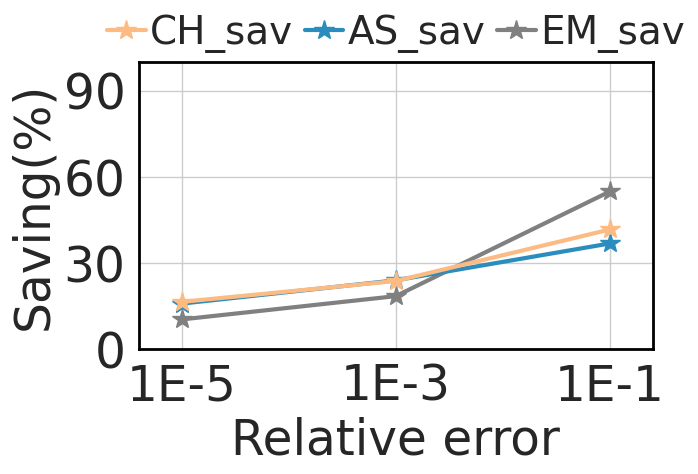

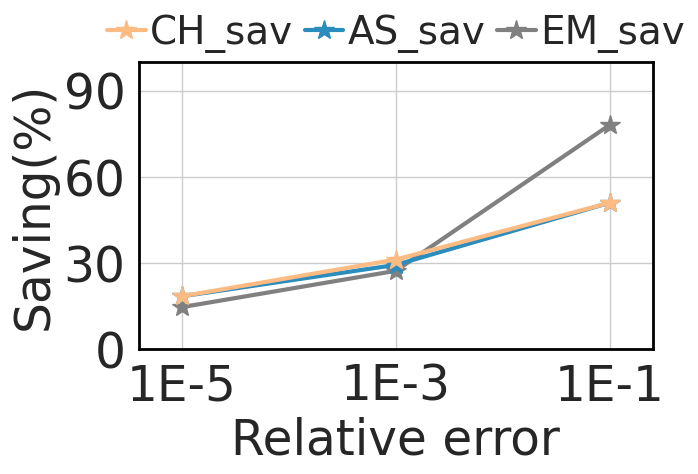

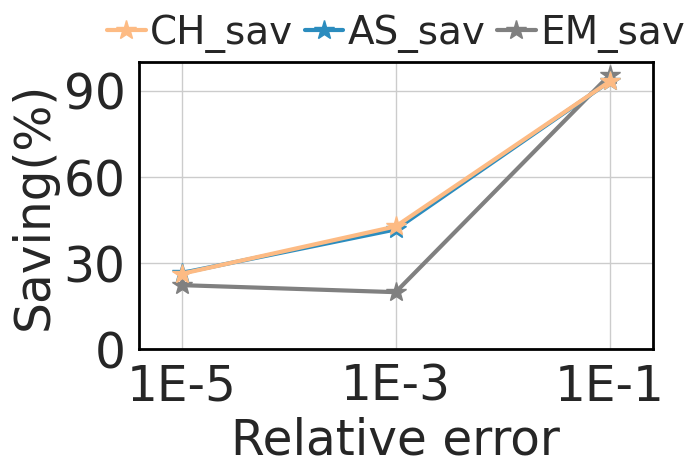

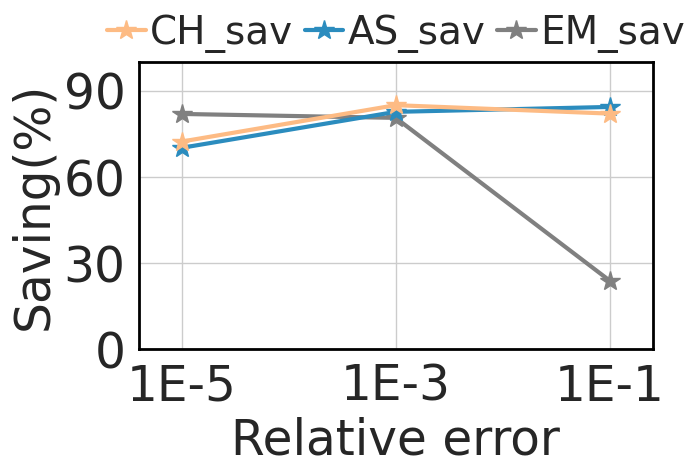

In [ ]:
# FG-MGARD vs EMGARD
# dnames = ["cloudf48", "precipf48", "qgraupf48", "qicef48", "pres", "qc", "qg-", "qi-",  "baryon_density", "dark_matter_density", "temperature", "velocity_x"]
dnames = ["cloudf48", "precipf48", "pres", "baryon_density"]
relative_error = [1e-5, 1e-3, 1e-1]
data_as = pd.read_csv("as_optimization.csv")
data_ch = pd.read_csv("ch_optimization.csv")
data_em = pd.read_csv("emgard.csv")

threshold = 0.05

import itertools
def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

for i in np.arange(0, len(dnames)):
    plt.rcParams["figure.figsize"] = [7, 5]
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111) # io
    # ax2 = fig1.add_subplot(111) # max error
    dname = dnames[i]

    abs             = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].abserr.values
    io_baseline     = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].baseline_io.values
    io_as           = data_as[data_as.dname.str.contains(dname) & (data_as.threshold == threshold)].Total_retrieve_size.values
    io_ch           = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Total_retrieve_size.values
    io_em           = data_em[data_em.dname.str.contains(dname)].Total_retrieve_size.values*1.2
    maxerr_baseline = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].baseline_maxerr.values
    maxerr_as       = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Compression_error.values
    maxerr_ch       = data_ch[data_ch.dname.str.contains(dname) & (data_ch.threshold == threshold)].Compression_error.values
    maxerr_em       = data_em[data_em.dname.str.contains(dname)].Compression_error.values

    if dname in ["pres", "baryon_density"]:
        io_em[0] = io_em[0]*5
        io_em[1] = io_em[1]*2

    maxerr_em = maxerr_em*.3

    io_em = np.flip(io_em)
    maxerr_em = np.flip(maxerr_em)

    ax1.plot(np.arange(len(io_em)), (io_baseline - io_em)/io_baseline*100, lw=3, marker="*", markersize=15, color="grey", label="EM_sav")
    ax1.plot(np.arange(len(io_as)), (io_baseline - io_as)/io_baseline*100, lw=3, marker="*", markersize=15, color="#2b8cbe", label="AS_sav")
    ax1.plot(np.arange(len(io_as)), (io_baseline - io_ch)/io_baseline*100, lw=3, marker="*", markersize=15, color="#fdbb84", label="CH_sav")

    ax2.plot(np.arange(len(maxerr_ch)),           maxerr_ch,       lw=3, marker="*", markersize=15, color=current_palette[1], label="CH")
    ax2.plot(np.arange(len(maxerr_as)),           maxerr_as,       lw=3, marker="*", markersize=15, color=current_palette[0], label="AS")
    ax2.plot(np.arange(len(maxerr_em)),           maxerr_em,       lw=3, marker="*", markersize=15, color="grey",  label="EM")
    ax2.plot(np.arange(len(maxerr_baseline)),     maxerr_baseline, lw=3, marker="*", markersize=15, color="black", label="BL")
    ax2.plot(np.arange(len(maxerr_baseline)),     abs,             lw=3, marker="*", markersize=15, color="red", label="Input")

    ax1.set_ylim((0, 100))
    ax1.set_xlim((-.2, 2.2))
    ax2.set_xlim((-.2, 2.2))
    ax1.set_xticks(np.arange(len(io_as)))
    ax1.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize)
    ax2.set_xticks(np.arange(len(io_as)))
    ax2.set_xticklabels(["1E-5", "1E-3", "1E-1"], fontsize=fontsize)
    ax1.set_yticks([0, 30, 60, 90])
    ax1.set_yticklabels(["0", "30", "60", "90"], fontsize=fontsize)

    ax2.set_yscale("log")
    if dname == "cloudf48":
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "precipf48":
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "qgraupf48":
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "qicef48":
        ax2.set_yticks([1e-5, 1e-3, 1e-1, 1e+1])
        ax2.set_yticklabels(["1e-5", "1e-3", "1e-1", "1e+1"], fontsize=fontsize)
    if dname == "pres":
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "qc":
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "qg-":
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "qi-":
        ax2.set_yticks([1e-9, 1e-7, 1e-5, 1e-3])
        ax2.set_yticklabels(["1e-9", "1e-7", "1e-5", "1e-3"], fontsize=fontsize)
    if dname == "baryon_density":
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "dark_matter_density":
        ax2.set_yticks([1e-2, 1e0, 1e2, 1e4])
        ax2.set_yticklabels(["1e-2", "1e+0", "1e+2", "1e+4"], fontsize=fontsize)
    if dname == "temperature":
        ax2.set_yticks([1e1, 1e3, 1e5, 1e7])
        ax2.set_yticklabels(["1e+1", "1e+3", "1e+5", "1e+7"], fontsize=fontsize)
    if dname == "velocity_x":
        ax2.set_yticks([1e2, 1e4, 1e6, 1e8])
        ax2.set_yticklabels(["1e+2", "1e+4", "1e+6", "1e+8"], fontsize=fontsize)

    ax1.set_xlabel("Relative error",      fontsize=fontsize)
    # ax1.set_ylabel("I/O size (MB)",       fontsize=fontsize)
    ax1.set_ylabel("Saving(%)",   fontsize=fontsize)
    ax2.set_xlabel("Relative error",      fontsize=fontsize)
    ax2.set_ylabel("Max error", fontsize=fontsize)

    ax1.spines["bottom"].set_color("black")
    ax1.spines["top"].set_color("black")
    ax1.spines["right"].set_color("black")
    ax1.spines["left"].set_color("black")

    ax2.spines["bottom"].set_color("black")
    ax2.spines["top"].set_color("black")
    ax2.spines["right"].set_color("black")
    ax2.spines["left"].set_color("black")

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[::-1], labels[::-1], frameon=False, fancybox=False, ncol=3, bbox_to_anchor=(.5, 1.1), loc='center', fontsize=fontsize*0.8, handlelength=1, handletextpad=.1, borderpad=.1, columnspacing=.3, labelspacing=.1)
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles[::-1], labels[::-1], frameon=False, fancybox=False, ncol=5, bbox_to_anchor=(.45, 1.1), loc='center', fontsize=fontsize*0.8, handlelength=1, handletextpad=.1, borderpad=.1, columnspacing=.3, labelspacing=.1)

    fig1.tight_layout()
    # plt.savefig("{}_IO_EM.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")
    # plt.savefig("{}_ME_EM.pdf".format(dname.replace("_lvl3", "").replace(".csv", "")), dpi="figure", bbox_inches="tight", format="pdf")

In [ ]:
data_em

,dname,c0,c1,c2,abserr,estimated_error,l0,l1,l2,Total_retrieve_size,Compression_error
0,pres-98x1200x1200,0.242,0.202,0.28,9.953480e+03,9.879550e+03,6,3,2,79198,1.736000e+04
1,qc-98x1200x1200,0.242,0.202,0.28,3.012000e-04,2.648930e-04,7,5,5,529855,6.066270e-04
2,qg-98x1200x1200,0.242,0.202,0.28,1.488100e-03,1.059570e-03,8,6,5,342243,2.838530e-03
3,qi-98x1200x1200,0.242,0.202,0.28,1.601000e-04,1.472170e-04,7,6,5,265401,3.347210e-04
4,cloudf48_log,0.242,0.202,0.28,1.015200e+00,7.922500e-01,10,7,6,3803943,2.313550e+00
5,precipf48_log,0.242,0.202,0.28,3.580140e+00,3.290000e+00,9,8,7,2002264,8.301540e+00
6,qgraupf48_log,0.242,0.202,0.28,3.576560e+00,3.169000e+00,10,8,7,4055851,8.609110e+00
7,qicef48_log,0.242,0.202,0.28,1.868310e+00,1.645000e+00,9,8,6,2524928,4.752830e+00
8,baryon_density,0.242,0.202,0.28,1.158620e+04,9.879550e+03,3,5,5,3742,1.516680e+04
9,dark_matter_density,0.242,0.202,0.28,1.377890e+03,1.234940e+03,4,5,4,6851,1.976540e+03


from matplotlib import pyplot as plt
data_em['abserr'].plot(kind='hist', bins=20, title='abserr')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em['estimated_error'].plot(kind='hist', bins=20, title='estimated_error')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em['l0'].plot(kind='hist', bins=20, title='l0')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em['l1'].plot(kind='hist', bins=20, title='l1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em.plot(kind='scatter', x='abserr', y='estimated_error', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em.plot(kind='scatter', x='estimated_error', y='l0', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em.plot(kind='scatter', x='l0', y='l1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data_em.plot(kind='scatter', x='l1', y='l2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['c0']
  ys = series['abserr']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data_em.sort_values('c0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('c0')
_ = plt.ylabel('abserr')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['c0']
  ys = series['estimated_error']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data_em.sort_values('c0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('c0')
_ = plt.ylabel('estimated_error')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['c0']
  ys = series['l0']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data_em.sort_values('c0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('c0')
_ = plt.ylabel('l0')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['c0']
  ys = series['l1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data_em.sort_values('c0', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('c0')
_ = plt.ylabel('l1')

from matplotlib import pyplot as plt
data_em['abserr'].plot(kind='line', figsize=(8, 4), title='abserr')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data_em['estimated_error'].plot(kind='line', figsize=(8, 4), title='estimated_error')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data_em['l0'].plot(kind='line', figsize=(8, 4), title='l0')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data_em['l1'].plot(kind='line', figsize=(8, 4), title='l1')
plt.gca().spines[['top', 'right']].set_visible(False)

## Traditonal optimization (deprecated)

### optimization with simulated annealing

- we have 3 parameter to search in total: c0, c1, c2;

In [ ]:
# import math
# import random

# # def loss_function(x, y):
# #     # Rosenbrock function
# #     return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

# def loss_function(data, c0, c1, c2):
#     # print(c0)
#     c1 = 5.54
#     c2 = 5.54
#     medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
#     redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
#     trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
#     # return np.abs(medata - redata)*trsdata
#     return relu(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata)

# def acceptance_probability(current_loss, neighbor_loss, temperature):
#     if neighbor_loss < current_loss:
#         return 1.0
#     return math.exp((current_loss - neighbor_loss) / temperature)

# def simulated_annealing_optimizer(data):
#     # Initial solution
#     # current_solution = [np.random.randint(1, 554 + 1)/100, np.random.randint(1, 554 + 1)/100, np.random.randint(1, 554 + 1)/100]
#     # current_solution = [np.random.randint(1, 554 + 1)/100, 5.54, 5.54]
#     current_solution = [.5, 5.54, 5.54]
#     best_solution = current_solution

#     # Parameters
#     initial_temperature = 10000000000000000.0
#     final_temperature = 0.01
#     cooling_rate = 0.3

#     # Start annealing process
#     temperature = initial_temperature
#     while temperature > final_temperature:
#         # Generate a neighboring solution
#         # neighbor = [current_solution[0] + np.random.randint(-1, 2)/100,
#         #             current_solution[1] + np.random.randint(-1, 2)/100,
#         #             current_solution[2] + np.random.randint(-1, 2)/100]
#         neighbor = [np.round(current_solution[0] + np.random.randint(-1, 2)/100, 2),
#                     5.54,
#                     5.54]

#         if neighbor[0] > 5.54:
#             neighbor[0] = 5.54
#         if neighbor[0] < 0.01:
#             neighbor[0] = 0.01

#         # Calculate the loss for the current and neighboring solutions
#         current_loss = loss_function(data, current_solution[0], current_solution[1], current_solution[2])
#         neighbor_loss = loss_function(data, neighbor[0], neighbor[1], neighbor[2])

#         print(current_solution, temperature, current_loss)

#         # Decide whether to move to the neighboring solution
#         if random.random() < acceptance_probability(current_loss, neighbor_loss, temperature):
#             current_solution = neighbor

#         # Update the best solution
#         if loss_function(data, current_solution[0], current_solution[1], current_solution[2]) < loss_function(data, best_solution[0], best_solution[1], best_solution[2]):
#             best_solution = current_solution

#         # Cool down the temperature
#         temperature *= (1 - cooling_rate)

#     return best_solution

# # Usage
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format("1e-5"))).drop_duplicates()

# best_solution = simulated_annealing_optimizer(data0)
# best_loss = loss_function(data0, best_solution[0], best_solution[1], best_solution[2])

# print("Best solution:", best_solution)
# print("Loss:", best_loss)


In [ ]:
# data = data0
# c0 = 0.2
# c1 = 5.54
# c2 = 5.54
# medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
# redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
# trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
# print(medata, redata, trsdata, np.abs(medata - redata)*trsdata)

### optimization with genetic algorithm

- we have 3 parameter to search in total: c0, c1, c2;

In [ ]:
# import math
# import random

# def loss_function(data, c0, c1, c2):
#     # print(c0, c1, c2)
#     medata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].MaxErr.values[0]
#     redata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Requested_tolerance.values[0]
#     trsdata = data[(data.c0 == c0) & (data.c1 == c1) & (data.c2 == c2)].Total_retrieve_size.values[0]
#     # return np.abs(medata - redata)*trsdata
#     return relu(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata)

# def generate_initial_population(population_size):
#     # Generate an initial population of random solutions
#     population = []
#     for _ in range(population_size):
#         solution = [np.random.randint(1, 554 + 1)/100, 5.54, 5.54]
#         population.append(solution)
#     return population

# def select_parents(data, population, num_parents):
#     # Select the best parents from the population based on their fitness
#     population = sorted(population, key=lambda x: loss_function(data, x[0], x[1], x[2]))
#     parents = population[:num_parents]
#     return parents

# def crossover(parents, num_offspring):
#     # Perform crossover to generate offspring
#     offspring = []
#     for _ in range(num_offspring):
#         parent1, parent2 = random.sample(parents, 2)
#         child = [parent1[0], parent2[1], parent1[2]]  # Example crossover operation
#         offspring.append(child)
#     return offspring

# def mutate(offspring, mutation_rate):
#     # Perform mutation on the offspring
#     for child in offspring:
#         if random.random() < mutation_rate:
#             # child[0] += random.uniform(-1, 1)  # Example mutation operation
#             child[0] = np.round(child[0] + np.random.randint(-1, 2)/100, 2)
#             # child[1] += random.uniform(-1, 1)  # Example mutation operation

#         if child[0] > 5.54:
#             child[0] = 5.54
#         if child[0] < 0.01:
#             child[0] = 0.01
#     return offspring

# def genetic_algorithm_optimizer(data):
#     # Parameters
#     population_size = 100
#     num_generations = 100
#     num_parents = 20
#     num_offspring = population_size - num_parents
#     mutation_rate = 0.1

#     # Generate initial population
#     population = generate_initial_population(population_size)

#     # Start evolution process
#     for _ in range(num_generations):
#         # Select parents
#         parents = select_parents(data, population, num_parents)

#         # Perform crossover
#         offspring = crossover(parents, num_offspring)
#         # print(offspring)

#         # Perform mutation
#         offspring = mutate(offspring, mutation_rate)

#         # Create the new population
#         population = parents + offspring

#     # Select the best solution from the final population
#     best_solution = min(population, key=lambda x: loss_function(data, x[0], x[1], x[2]))

#     return best_solution

# # Usage
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format("1e-5"))).drop_duplicates()

# best_solution = genetic_algorithm_optimizer(data0)
# best_loss = loss_function(data0, best_solution[0], best_solution[1], best_solution[2])

# print("Best solution:", best_solution)
# print("Loss:", best_loss)


In [ ]:
# Best solution: [0.02, 5.54, 5.54]
# Loss: 26174.775165000017

# Best solution: [0.09, 5.54, 5.54]
# Loss: 156678.359454

In [ ]:
# def relu(x):
#     return max(0, x)

# def relu_array(input_array):
#     return [relu(x) for x in input_array]

In [ ]:
# relu_array([-1, 1, 2, -2])

## MLP for mapping factor prediction (moved to DNN_Mgard_train.ipynb)

In [ ]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.utils.data as Data
# from torch.autograd import Variable
# from torch.optim import *

# import copy
# from sklearn import preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# import random
# random.seed(10)

In [ ]:
# # correlation
# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values

# # target_feature  = traintest_data[["relerr", "reqerr", "threshold", "c0", "c1", "c2"]].copy()

# # plt.figure(figsize=(5, 5))
# # ticklabels = ["relerr", "reqerr", "threshold", "c0", "c1", "c2"]
# # heatmap = sns.heatmap(target_feature.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"size":10}, yticklabels=ticklabels, xticklabels=ticklabels)
# # sns.set(font_scale=1)
# # cbar = heatmap.collections[0].colorbar
# # cbar.ax.tick_params(labelsize=15)

# dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log",
#           "baryon_density", "dark_matter_density", "temperature", "velocity_x",
#           "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",]

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(len(dnames)):

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     drange = data.drange.values
#     c0 = data.c0.values
#     c1 = data.c1.values
#     c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

In [ ]:
# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(3):

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     threshold = data.threshold.values
#     reqerr = data.reqerr.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(threshold)), threshold)
#     ax1.plot(np.arange(len(reqerr)), reqerr)
#     ax1.set_yscale("log")

In [ ]:
# def preprocess(traintest_data, num_lvl, split_ratio=0.2, shuffle=True):

#     df_data_feature = traintest_data[["relerr", "reqerr", "threshold"]].copy()
#     df_data_target  = traintest_data[["c2"]].copy()

#     # if num_lvl == 2:
#     #     df_data_target  = traintest_data[["c0", "c1"]].copy()
#     # elif num_lvl == 3:
#     #     df_data_target  = traintest_data[["c0", "c1", "c2"]].copy()
#     # elif num_lvl == 4:
#     #     df_data_target  = traintest_data[["c0", "c1", "c2", "c3"]].copy()

#     data_feature  = np.array(df_data_feature.astype("float32"))
#     data_target   = np.array(df_data_target.astype("float32"))

#     X_train, X_test, Y_train, Y_test = train_test_split(data_feature, data_target, test_size=split_ratio,
#                                                         shuffle=shuffle, random_state=233)

#     normalizer = preprocessing.Normalizer()
#     normalized_train_X = normalizer.fit_transform(X_train)
#     normalized_test_X  = normalizer.transform(X_test)

#     return normalized_train_X, normalized_test_X, Y_train, Y_test

# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values
# traintest_data = traintest_data[traintest_data['dname'].str.contains('cloudf48')]
# normalized_train_X, normalized_test_X, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.2, shuffle=False)

In [ ]:
# class MLP(torch.nn.Module):
#     def __init__(self):
#         super(MLP, self).__init__()

#         self.model1 = torch.nn.Sequential(
#             torch.nn.Linear(3, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 1),
#         )

#         self.model2 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 2),
#         )

#         self.model3 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 3),
#         )

#         self.model4 = torch.nn.Sequential(
#             torch.nn.Linear(2, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 32),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(32, 16),
#             torch.nn.LeakyReLU(),
#             torch.nn.Linear(16, 4),
#         )

#     def forward(self, x):
#         output = self.main(x)
#         return output

# class MyLoss(nn.Module):
#     def __init__(self):
#         super(MyLoss, self).__init__()

#     def forward(self, prediction, target):
#         loss = torch.nn.L1Loss()(prediction, target)
#         return loss

In [ ]:

# def train(X_train, Y_train, num_lvl, num_epoch, learning_rate):
#     x_train = Variable(torch.from_numpy(X_train))
#     y_train = Variable(torch.from_numpy(Y_train))

#     net = MLP().model1
#     # if num_lvl == 2:
#     #     net = MLP().model2
#     # elif num_lvl == 3:
#     #     net = MLP().model3
#     # elif num_lvl == 4:
#     #     net = MLP().model4

#     print(net)
#     net = net.to("cuda")

#     optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
#     loss_func = MyLoss()

#     BATCH_SIZE = 64
#     EPOCH = num_epoch

#     torch_dataset = Data.TensorDataset(x_train, y_train)

#     loader = Data.DataLoader(
#         dataset=torch_dataset,
#         batch_size=BATCH_SIZE,
#         shuffle=True, num_workers=4,)

#     # start training
#     print("Training: model{}".format(num_lvl))
#     for epoch in range(EPOCH):
#         for step, (batch_x, batch_y) in enumerate(loader): # for each training step
#             b_x = Variable(batch_x)
#             b_y = Variable(batch_y)
#             b_x = b_x.to("cuda")
#             b_y = b_y.to("cuda")
#             prediction = net(b_x)     # input x and predict based on x
#             loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)
#             optimizer.zero_grad()   # clear gradients for next train
#             loss.backward()         # backpropagation, compute gradients
#             optimizer.step()        # apply gradients

#         if epoch % 100 == 0:
#             # print(loss.detach().numpy())
#             print(loss.to("cpu").detach().numpy())
#     return net

In [ ]:
# def inference(feature, net, target):
#     feature = Variable(torch.from_numpy(feature))
#     target = Variable(torch.from_numpy(target))

#     feature = feature.to("cuda")
#     target = target.to("cuda")
#     prediction = net(feature)
#     return target.to("cpu").detach().numpy(), prediction.to("cpu").detach().numpy()

In [ ]:
# def validate_var(net, dname):
#     traintest_data = pd.read_csv("traintest_3d_convex.csv")
#     traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values
#     traintest_data = traintest_data[traintest_data['dname'].str.contains(dname)]
#     X_train, X_test, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.9, shuffle=False)
#     target, prediction = inference(X_test, net, Y_test)

#     return target, prediction

# # validate_var(net)

In [ ]:
# if __name__ == "__main__":
#     # the main starts here
#     traintest_data = pd.read_csv("traintest_3d_convex.csv")
#     # traintest_data = traintest_data[traintest_data['dname'].str.contains('cloudf48_log')]
#     X_train, X_test, Y_train, Y_test = preprocess(traintest_data, num_lvl=3, split_ratio=0.1, shuffle=False)

#     print(np.shape(X_train), np.shape(Y_train), np.shape(X_test), np.shape(Y_test))
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=3200, learning_rate=0.0001)

In [ ]:
# dnames = ["cloudf48_log", "precipf48_log", "qgraupf48_log", "qicef48_log",
#           "baryon_density", "dark_matter_density", "temperature", "velocity_x",
#           "pres-98x1200x1200", "qc-98x1200x1200", "qg-98x1200x1200","qi-98x1200x1200",]

# traintest_data = pd.read_csv("traintest_3d_convex.csv")
# traintest_data["relerr"] = traintest_data.reqerr.values/traintest_data.drange.values

# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(4): # len(dnames)

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.2, shuffle=False)
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=1200, learning_rate=0.01)

#     target, prediction = validate_var(net, dname)

#     # drange = data.drange.values
#     # c0 = data.c0.values
#     # c1 = data.c1.values
#     # c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i+1)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     # ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(target)), target, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(prediction)), prediction, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

In [ ]:
# plt.rcParams["figure.figsize"] = [20, 15]
# fig1 = plt.figure()
# for i in np.arange(4, len(dnames)): # len(dnames)

#     dname = dnames[i]
#     data = traintest_data[traintest_data['dname'].str.contains(dname)]

#     X_train, X_test, Y_train, Y_test = preprocess(data, num_lvl=3, split_ratio=0.2, shuffle=False)
#     net = train(X_train, Y_train, num_lvl=3, num_epoch=1200, learning_rate=0.01)

#     target, prediction = validate_var(net, dname)

#     # drange = data.drange.values
#     # c0 = data.c0.values
#     # c1 = data.c1.values
#     # c2 = data.c2.values

#     ax1 = fig1.add_subplot(3, 4, i-3)
#     # ax1.plot(np.arange(len(c0)), c0, label="{}-c0".format(dname))
#     # ax1.plot(np.arange(len(c1)), c1, label="{}-c1".format(dname))
#     # ax1.plot(np.arange(len(c2)), c2, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(target)), target, label="{}-c2".format(dname))
#     ax1.plot(np.arange(len(prediction)), prediction, label="{}-c2".format(dname))

#     ax1.set_yticks([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6]);
#     ax1.set_yticklabels([0, .2, .4, .6, .8, 1, 1.2, 1.4, 1.6], fontsize=fontsize);
#     ax1.text(120, 1.5, "dname={}".format(data.dname.values[0].replace(".csv", "")), horizontalalignment="right")
#     ax1.text(120, 1.4, "drange={}".format(data.drange.values[0]), horizontalalignment="right")

## Misc

In [ ]:
# def plot_various(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)
#     ax4 = fig.add_subplot(334)
#     ax5 = fig.add_subplot(335)
#     ax6 = fig.add_subplot(336)
#     ax7 = fig.add_subplot(337)
#     ax8 = fig.add_subplot(338)
#     ax9 = fig.add_subplot(339)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     ax1.plot(xdata, trsdata, "s", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax2.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax2.plot(xdata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax2x = ax2.twinx()
#     ax2x.plot(xdata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax2x.set_ylim(0, 100)
#     ax2.set_xlabel("C0", fontsize=fontsize)
#     ax2.set_ylabel("Esti'd error", fontsize=fontsize)

#     ax3.plot(xdata, eedata/xdata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax3.set_yscale("log")
#     ax3.set_xlabel("C0", fontsize=fontsize)
#     ax3x = ax3.twinx()
#     ax3x.plot(xdata, 1/l0, linewidth=2, label="Reciprocal of bit plane number")

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax4.plot(ydata, trsdata, "s", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax4.set_xlabel("C1", fontsize=fontsize)
#     ax4.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax5.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax5.plot(ydata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax5x = ax5.twinx()
#     ax5x.plot(ydata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax5x.set_ylim(0, 100)
#     ax5.set_xlabel("C1", fontsize=fontsize)
#     ax5.set_ylabel("Compr'n error", fontsize=fontsize)

#     ax6.plot(ydata, eedata/ydata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax6.set_yscale("log")
#     ax6.set_xlabel("C1", fontsize=fontsize)
#     ax6x = ax6.twinx()
#     ax6x.plot(ydata, 1/l1, linewidth=2, label="Reciprocal of bit plane number")

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax7.plot(zdata, trsdata, "o", markersize=2, color=current_palette[0], label="Retrieved size")
#     ax7.set_xlabel("C2", fontsize=fontsize)
#     ax7.set_ylabel("Retrieval size", fontsize=fontsize)

#     # ax8.plot(np.linspace(0, 6, 1000), [.8]*1000, "s", markersize=1, color="gray")
#     ax8.plot(zdata, eedata, "s", markersize=2, color=current_palette[0], label="Estimated")
#     ax8x = ax8.twinx()
#     ax8x.plot(zdata, medata, "s", markersize=2, color=current_palette[1], label="Achieved")
#     # ax8x.set_ylim(0, 100)
#     ax8.set_xlabel("C2", fontsize=fontsize)
#     ax8.set_ylabel("Compr'n error", fontsize=fontsize)

#     ax9.plot(zdata, eedata/zdata, "s", markersize=2, color=current_palette[2], label="Error gradient")
#     ax9.set_yscale("log")
#     ax9.set_xlabel("C2", fontsize=fontsize)
#     ax9x = ax9.twinx()
#     ax9x.plot(zdata, 1/l2, linewidth=2, label="Reciprocal of bit plane number")

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax4.set_xticks(np.arange(0, 7))
#     ax5.set_xticks(np.arange(0, 7))
#     ax6.set_xticks(np.arange(0, 7))
#     ax7.set_xticks(np.arange(0, 7))
#     ax8.set_xticks(np.arange(0, 7))
#     ax9.set_xticks(np.arange(0, 7))

#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax4.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax5.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax6.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax7.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax8.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax9.set_xticklabels(np.arange(0, 7), fontsize=fontsize)

#     # ax2.set_ylim(55, 85)
#     # ax5.set_ylim(55, 85)
#     # ax8.set_ylim(55, 80)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")


#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)
#     # ax5.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .2), loc='center', fontsize=15)

#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)
#     # ax4.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)
#     # ax6.legend(frameon=False, ncol=1, bbox_to_anchor=(.8, .2), loc='right', fontsize=15)

#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)
#     # ax6.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)
#     # ax9.legend(frameon=False, ncol=1, bbox_to_anchor=(1, .2), loc='right', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     # ax2.spines["bottom"].set_color("black")
#     # ax2.spines["top"].set_color("black")
#     # ax2.spines["right"].set_color("black")
#     # ax2.spines["left"].set_color("black")

#     # ax3.spines["bottom"].set_color("black")
#     # ax3.spines["top"].set_color("black")
#     # ax3.spines["right"].set_color("black")
#     # ax3.spines["left"].set_color("black")

#     ax4.spines["bottom"].set_color("black")
#     ax4.spines["top"].set_color("black")
#     ax4.spines["right"].set_color("black")
#     ax4.spines["left"].set_color("black")

#     # ax5.spines["bottom"].set_color("black")
#     # ax5.spines["top"].set_color("black")
#     # ax5.spines["right"].set_color("black")
#     # ax5.spines["left"].set_color("black")

#     # ax6.spines["bottom"].set_color("black")
#     # ax6.spines["top"].set_color("black")
#     # ax6.spines["right"].set_color("black")
#     # ax6.spines["left"].set_color("black")

#     ax7.spines["bottom"].set_color("black")
#     ax7.spines["top"].set_color("black")
#     ax7.spines["right"].set_color("black")
#     ax7.spines["left"].set_color("black")

#     ax2x.spines["bottom"].set_color("black")
#     ax2x.spines["top"].set_color("black")
#     ax2x.spines["left"].set_color("black")
#     ax2x.spines["right"].set_color("black")

#     ax5x.spines["bottom"].set_color("black")
#     ax5x.spines["top"].set_color("black")
#     ax5x.spines["left"].set_color("black")
#     ax5x.spines["right"].set_color("black")

#     ax8x.spines["bottom"].set_color("black")
#     ax8x.spines["top"].set_color("black")
#     ax8x.spines["left"].set_color("black")
#     ax8x.spines["right"].set_color("black")

#     ax3x.spines["bottom"].set_color("black")
#     ax3x.spines["top"].set_color("black")
#     ax3x.spines["left"].set_color("black")
#     ax3x.spines["right"].set_color("black")

#     ax6x.spines["bottom"].set_color("black")
#     ax6x.spines["top"].set_color("black")
#     ax6x.spines["left"].set_color("black")
#     ax6x.spines["right"].set_color("black")

#     ax9x.spines["bottom"].set_color("black")
#     ax9x.spines["top"].set_color("black")
#     ax9x.spines["left"].set_color("black")
#     ax9x.spines["right"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "ex")
# plot_various(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "jx")
# plot_various(time_path, "1e-1")

In [ ]:
# def plot_Error(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 3])
#     ax1 = fig.add_subplot(131)
#     ax2 = fig.add_subplot(132)
#     ax3 = fig.add_subplot(133)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     ax1.plot(xdata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c0_maxerror")
#     ax1.plot(xdata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c0_estierror")

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax2.plot(ydata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c1_maxerror")
#     ax2.plot(ydata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c1_estierror")

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax3.plot(zdata, medata, markersize=2, color=current_palette[0], marker="s", alpha=.5, label="c2_maxerror")
#     ax3.plot(zdata, eedata, markersize=2, color=current_palette[1], marker="s", alpha=.5, label="c2_estierror")
#     # ax1.set_xlabel("time_02_bx", fontsize=fontsize)
#     # ax1.set_ylabel("Error", fontsize=fontsize)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_Error(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_Error(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "ex")
# plot_Error(time_path)

# time_path = "datasets/time_00{}0_{}".format("30", "jx")
# plot_Error(time_path)

In [ ]:
# def plot_IO(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     # print(trsdata[0:10])
#     ax1.plot(xdata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data10, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data20, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data30, sort=True)
#     # # print(trsdata[0:10])
#     # ax1.plot(xdata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Retrieval size", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     ax2.plot(ydata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data11, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data21, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data31, sort=True)
#     # ax2.plot(ydata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Retrieval size", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     ax3.plot(zdata, trsdata, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data12, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[1], marker="^", alpha=.3, label="30_bx")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data22, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[2], marker="^", alpha=.3, label="30_ex")
#     # xdata, ydata, zdata, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data32, sort=True)
#     # ax3.plot(zdata, trsdata, markersize=1, color=current_palette[3], marker="^", alpha=.3, label="30_jx")
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Retrieval size", fontsize=fontsize)

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-3")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_IO(time_path, "1e-5")

In [ ]:
# def plot_BP(time_path, relerr):

#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates().sort_values(by="c0")
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates().sort_values(by="c1")
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates().sort_values(by="c2")

#     fig = plt.figure(figsize=[16, 9])
#     ax1 = fig.add_subplot(331)
#     ax2 = fig.add_subplot(332)
#     ax3 = fig.add_subplot(333)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0)
#     ax1.plot(xdata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax1.plot(xdata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.plot(xdata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1)
#     ax2.plot(ydata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax2.plot(ydata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.plot(ydata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2)
#     ax3.plot(zdata, l0, markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax3.plot(zdata, l1, markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.plot(zdata, l2, markersize=2, color=current_palette[2], marker="^", alpha=.5)
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Num. of Bitplanes", fontsize=fontsize)

#     ax1.set_xticks(np.arange(0, 7))
#     ax2.set_xticks(np.arange(0, 7))
#     ax3.set_xticks(np.arange(0, 7))
#     ax1.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax2.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     ax3.set_xticklabels(np.arange(0, 7), fontsize=fontsize)
#     #
#     # ax1.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax2.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)
#     # ax3.legend(frameon=False, ncol=1, bbox_to_anchor=(.7, .3), loc='center', fontsize=15)

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_BP(time_path, "1e-1")
# plot_BP(time_path, "1e-3")
# plot_BP(time_path, "1e-5")

In [ ]:
# def relu(x):
#     return max(0, x)

# def relu_array(input_array):
#     return [relu(x) for x in input_array]

In [ ]:
# def plot_Loss(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()
#     data3 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_full.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[16, 3])
#     ax1 = fig.add_subplot(141)
#     ax2 = fig.add_subplot(142)
#     ax3 = fig.add_subplot(143)
#     ax4 = fig.add_subplot(144)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data0, sort=True)
#     # ax1.plot(xdata, medata/trsdata/np.max(medata/trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax1.plot(xdata, medata/np.max(medata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax1.plot(xdata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.plot(xdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax1.plot([1/(3**3)/(2*(0 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax1.set_xlabel("C0", fontsize=fontsize)
#     ax1.set_ylabel("Loss function", fontsize=fontsize)
#     #
#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data1, sort=True)
#     # ax2.plot(ydata, medata/trsdata/np.max(medata/trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(eedata - redata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(medata - redata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     # ax2.plot(ydata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.plot(ydata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax2.plot([1/(3**3)/(2*(1 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax2.set_xlabel("C1", fontsize=fontsize)
#     ax2.set_ylabel("Loss function", fontsize=fontsize)

#     #
#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data2, sort=True)
#     # ax3.plot(zdata, np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.plot(zdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax3.plot([1/(3**3)/(2*(2 + 1))]*20, np.linspace(0, 1, 20), markersize=2, color=current_palette[1], marker="^", alpha=.5)
#     ax3.set_xlabel("C2", fontsize=fontsize)
#     ax3.set_ylabel("Loss function", fontsize=fontsize)

#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data3, sort=True)
#     ax4.plot(xdata, relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), markersize=2, color=current_palette[0], marker="^", alpha=.5)
#     ax4.set_xlabel("All", fontsize=fontsize)
#     ax4.set_ylabel("Loss function", fontsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     ax1.spines["bottom"].set_color("black")
#     ax1.spines["top"].set_color("black")
#     ax1.spines["right"].set_color("black")
#     ax1.spines["left"].set_color("black")

#     ax2.spines["bottom"].set_color("black")
#     ax2.spines["top"].set_color("black")
#     ax2.spines["right"].set_color("black")
#     ax2.spines["left"].set_color("black")

#     ax3.spines["bottom"].set_color("black")
#     ax3.spines["top"].set_color("black")
#     ax3.spines["right"].set_color("black")
#     ax3.spines["left"].set_color("black")

#     # ax1.set_xlim(-0.01, 0.5)
#     # ax2.set_xlim(-0.01, 0.5)
#     # ax3.set_xlim(-0.01, 0.5)

#     # ax4.spines["bottom"].set_color("black")
#     # ax4.spines["top"].set_color("black")
#     # ax4.spines["right"].set_color("black")
#     # ax4.spines["left"].set_color("black")

#     plt.tight_layout()

In [ ]:
# time_path = "datasets/Nyx_baryon_density"
# plot_Loss(time_path, "1e-1")

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# plot_Loss(time_path, "1e-1")
# plot_Loss(time_path, "1e-3")
# plot_Loss(time_path, "1e-5")
# plot_Loss(time_path, "1e-7")

In [ ]:
# def scatter_Loss(time_path, relerr):
#     data0 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c0.csv".format(relerr))).drop_duplicates()
#     data1 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c1.csv".format(relerr))).drop_duplicates()
#     data2 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_c2.csv".format(relerr))).drop_duplicates()
#     data3 = pd.read_csv(os.path.join(time_path, "run_mgard_{}_full.csv".format(relerr))).drop_duplicates()

#     fig = plt.figure(figsize=[8, 8])
#     # ax1 = fig.add_subplot(141)
#     # ax2 = fig.add_subplot(142)
#     # ax3 = fig.add_subplot(143)
#     ax4 = fig.add_subplot(1, 1, 1, projection="3d")


#     xdata, ydata, zdata, reqerr, l0, l1, l2, redata, eedata, medata, trsdata = load_var(data3, sort=True)
#     img = ax4.scatter(xdata, ydata, zdata, c=relu_array(medata - redata)+np.abs(medata - redata)/np.max(np.abs(medata - redata))*trsdata/np.max(trsdata), cmap="viridis", alpha=.5)
#     # ax4.set_xlabel("All", fontsize=fontsize)
#     # ax4.set_ylabel("Loss function", fontsize=fontsize)

#     cbar = fig.colorbar(img, orientation="horizontal", fraction=0.08, pad=0.05)
#     cbar.ax.tick_params(labelsize=fontsize)

#     # # inset axes....
#     # axins = ax3.inset_axes([0.7, 0.1, 0.1, 0.8])
#     # axins.plot(np.arange(0, 5.4), [80]*6, "-", color="gray")
#     # axins.plot(zdata, eedata,  "-", markersize=2, label="Estimated error")
#     # axins.plot(zdata, medata,  "-", markersize=2, label="Achieved error")
#     # # subregion of the original image
#     # axins.set_xlim(-0.01, 0.1)
#     # axins.set_ylim(0, 300)
#     # axins0= axins.twinx()
#     # axins0.plot(zdata, trsdata, "*", markersize=2, label="Retrieved size")
#     # # axins.set_xticklabels([])
#     # # axins.set_yticklabels([])
#     # ax3.indicate_inset_zoom(axins, edgecolor="black")

#     # ax1.spines["bottom"].set_color("black")
#     # ax1.spines["top"].set_color("black")
#     # ax1.spines["right"].set_color("black")
#     # ax1.spines["left"].set_color("black")

#     # ax2.spines["bottom"].set_color("black")
#     # ax2.spines["top"].set_color("black")
#     # ax2.spines["right"].set_color("black")
#     # ax2.spines["left"].set_color("black")

#     # ax3.spines["bottom"].set_color("black")
#     # ax3.spines["top"].set_color("black")
#     # ax3.spines["right"].set_color("black")
#     # ax3.spines["left"].set_color("black")

#     # ax1.set_xlim(-0.01, 0.5)
#     # ax2.set_xlim(-0.01, 0.5)
#     # ax3.set_xlim(-0.01, 0.5)

#     # ax4.spines["bottom"].set_color("black")
#     # ax4.spines["top"].set_color("black")
#     # ax4.spines["right"].set_color("black")
#     # ax4.spines["left"].set_color("black")

#     plt.tight_layout()

# time_path = "datasets/time_00{}0_{}".format("30", "bx")
# scatter_Loss(time_path, "1e-7")

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_theme(style="whitegrid")

# # Load the example dataset of brain network correlations
# df = sns.load_dataset("brain_networks", header=[0, 1, 2], index_col=0)

# # Pull out a specific subset of networks
# used_networks = [1, 3, 4, 5, 6, 7, 8, 11, 12, 13, 16, 17]
# used_columns = (df.columns.get_level_values("network")
#                           .astype(int)
#                           .isin(used_networks))
# df = df.loc[:, used_columns]

# # Compute the correlation matrix and average over networks
# corr_df = df.corr().groupby(level="network").mean()
# corr_df.index = corr_df.index.astype(int)
# corr_df = corr_df.sort_index().T

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 6))

# # Draw a violinplot with a narrower bandwidth than the default
# sns.violinplot(data=corr_df, bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

# # Finalize the figure
# ax.set(ylim=(-.7, 1.05))
# sns.despine(left=True, bottom=True)